In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm.auto import tqdm
from collections import Counter
import string
import re
import time
from sklearn.feature_extraction.text import CountVectorizer
import sys

# Import functions from the utils file
from distilbert_lora_inference_utils import distilbert_lora_prediction

# Check if textstat is installed, if not install it
try:
    import textstat
except ImportError:
    print("Installing textstat...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textstat", "-q"])
    import textstat

from textstat import (
    flesch_reading_ease,
    flesch_kincaid_grade,
    dale_chall_readability_score,
    difficult_words,
)


# Analysis functions
def calculate_complexity(text):
    """Calculate text complexity metrics."""
    try:
        return pd.Series({
            'flesch_ease': flesch_reading_ease(text),
            'flesch_kincaid': flesch_kincaid_grade(text),
            'difficult_words': difficult_words(text),
            'dale_chall': dale_chall_readability_score(text)
        })
    except Exception:
        return pd.Series({
            'flesch_ease': np.nan, 'flesch_kincaid': np.nan,
            'difficult_words': np.nan, 'dale_chall': np.nan
        })

def plot_top_keywords(df, text_column, title_suffix, num_keywords=20, filename_suffix="", output_dir="."):
    """Create a plot of the top keywords in a text corpus."""
    if len(df) == 0:
        print(f"Skipping keyword analysis for '{title_suffix}': No samples.")
        return

    print(f"\nTop {num_keywords} Keywords for {title_suffix}:")
    try:
        vec = CountVectorizer(stop_words='english', max_features=num_keywords).fit(df[text_column])
        bag_of_words = vec.transform(df[text_column])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        top_df = pd.DataFrame(words_freq[:num_keywords], columns=['Keyword', 'Frequency'])
        print(top_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')
        plt.title(f'Top {num_keywords} Keywords ({title_suffix})')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"keywords_{filename_suffix}.png"))
        plt.show()

    except ValueError as e:
        print(f"Could not generate keywords for {title_suffix}: {e}") 

def get_top_ngrams(text_series, n=2, num_ngrams=20):
    """Extract the most common n-grams from a series of texts."""
    if len(text_series) == 0:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    # Simple whitespace and punctuation cleaning for n-grams
    def clean_for_ngrams(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) 
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    all_ngrams = []
    cleaned_texts = text_series.apply(clean_for_ngrams)
    for text in cleaned_texts:
        words = text.split()
        if len(words) >= n:
            grams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
            all_ngrams.extend(grams)

    if not all_ngrams:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    ngram_freq = Counter(all_ngrams)
    common_ngrams = ngram_freq.most_common(num_ngrams)
    return pd.DataFrame(common_ngrams, columns=[f'{n}-gram', 'Frequency'])

def plot_ngrams(df, title, filename, output_dir="."):
    """Plot the top n-grams."""
    if df.empty:
        print(f"Skipping plot for '{title}': No n-grams found.")
        return
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()


def run_error_analysis(processed_df, output_dir, use_features=False):
    """
    Run error analysis on the processed data.
    """
    # Define a model-specific prefix for output files
    prefix = f"{'with_features' if use_features else 'no_features'}_"
    
    # Separate by result type
    correct_df = processed_df[processed_df['is_correct']].copy()
    incorrect_df = processed_df[~processed_df['is_correct']].copy()
    tp_df = processed_df[processed_df['result_type'] == 'TP'].copy()
    tn_df = processed_df[processed_df['result_type'] == 'TN'].copy()
    fp_df = processed_df[processed_df['result_type'] == 'FP'].copy()
    fn_df = processed_df[processed_df['result_type'] == 'FN'].copy()

    if len(incorrect_df) == 0:
        print("\nNo misclassifications found on the validation set! Error analysis ends here.")

    # --- TEXT LENGTH ANALYSIS ---
    print("\n--- Analyzing Text Length ---")
    processed_df['text_length'] = processed_df['text'].apply(len)
    correct_df['text_length'] = correct_df['text'].apply(len)
    incorrect_df['text_length'] = incorrect_df['text'].apply(len)
    tn_df['text_length'] = tn_df['text'].apply(len)
    fp_df['text_length'] = fp_df['text'].apply(len)
    tp_df['text_length'] = tp_df['text'].apply(len)
    fn_df['text_length'] = fn_df['text'].apply(len)

    print("\nDescriptive Statistics for Text Length:")
    print("Correct Predictions:\n", correct_df['text_length'].describe())
    print("\nIncorrect Predictions:\n", incorrect_df['text_length'].describe())
    print("\nTN Predictions:\n", tn_df['text_length'].describe())
    print("\nFP Predictions:\n", fp_df['text_length'].describe())
    print("\nTP Predictions:\n", tp_df['text_length'].describe())
    print("\nFN Predictions:\n", fn_df['text_length'].describe())

    # Length histograms and boxplots
    plt.figure(figsize=(12, 6))
    sns.histplot(data=processed_df, x='text_length', hue='is_correct', kde=True, bins=50)
    plt.title('Text Length Distribution (Correct vs. Incorrect Predictions)')
    plt.xlabel('Text Length (Characters)')
    plt.ylabel('Count')
    plt.savefig(os.path.join(output_dir, f"{prefix}length_histogram.png"))
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=processed_df, x='is_correct', y='text_length')
    plt.title('Text Length Comparison (Correct vs. Incorrect)')
    plt.xlabel('Prediction Correct?')
    plt.ylabel('Text Length (Characters)')
    plt.xticks([0, 1], ['Incorrect', 'Correct'])
    plt.savefig(os.path.join(output_dir, f"{prefix}length_boxplot.png"))
    plt.show()

    # Length analysis by result type
    type_order = ['TN', 'FP', 'TP', 'FN']
    plot_data = processed_df[processed_df['result_type'].isin(type_order) & processed_df['text_length'].notna()].copy()

    if not plot_data.empty:
        plt.figure(figsize=(13, 7))
        sns.histplot(data=plot_data, x='text_length', hue='result_type', kde=True, bins=50,
                    hue_order=type_order, palette='viridis')
        plt.title('Text Length Distribution by Result Type (TP, TN, FP, FN)')
        plt.xlabel('Text Length (Characters)')
        plt.ylabel('Count')
        plt.legend(title='Result Type')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{prefix}length_histogram_by_type.png"))
        plt.show()

        plt.figure(figsize=(10, 7))
        sns.boxplot(data=plot_data, x='result_type', y='text_length',
                    order=type_order, palette='viridis')
        plt.title('Text Length Comparison by Result Type (TP, TN, FP, FN)')
        plt.xlabel('Result Type')
        plt.ylabel('Text Length (Characters)')
        plt.xticks(rotation=10) 
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{prefix}length_boxplot_by_type.png"))
        plt.show()

    # --- TEXT COMPLEXITY ANALYSIS ---
    print("\n--- Analyzing Text Complexity ---")
    tqdm.pandas(desc="Calculating Complexity")
    complexity_scores = processed_df['text'].progress_apply(calculate_complexity)
    processed_df = pd.concat([processed_df, complexity_scores], axis=1)

    # Compare average scores
    print("\nAverage Complexity Scores:")
    print(processed_df.groupby('is_correct')[['difficult_words']].mean())

    # Plot distributions
    complexity_metrics = ['difficult_words']
    for metric in complexity_metrics:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=processed_df, x=metric, hue='is_correct', kde=True, bins=40)
        plt.title(f'{metric.replace("_", " ").title()} Distribution (Correct vs. Incorrect)')
        plt.xlabel(metric.replace("_", " ").title())
        plt.ylabel('Count')
        plt.savefig(os.path.join(output_dir, f"{prefix}complexity_{metric}_hist.png"))
        plt.show()

    # Complexity by result type
    print("\n--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---")
    processed_df = processed_df.loc[:, ~processed_df.columns.duplicated(keep='first')]
    plot_data_four_types = processed_df[processed_df['result_type'].isin(type_order)].copy()

    print("\nDescriptive Statistics for Complexity Metrics by Result Type:")
    for metric in complexity_metrics:
        if metric in plot_data_four_types.columns:
            print(f"\n--- {metric.replace('_', ' ').title()} ---")
            stats = plot_data_four_types.groupby('result_type')[metric].describe()
            try:
                print(stats.reindex(type_order))
            except KeyError:
                print("Warning: Not all result types found in data for stats ordering.")
                print(stats) 
        else:
            print(f"Metric '{metric}' not found for descriptive stats.")

    # Plot complexity metrics by result type
    for metric in complexity_metrics:
        if metric in plot_data_four_types and pd.api.types.is_numeric_dtype(plot_data_four_types[metric]):
           
            plot_data_metric = plot_data_four_types.dropna(subset=[metric, 'result_type'])

            if not plot_data_metric.empty:
                # Box Plot
                plt.figure(figsize=(10, 6))
                sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')
                plt.title(f'{metric.replace("_", " ").title()} Comparison by Result Type')
                plt.xlabel('Result Type')
                plt.ylabel(metric.replace("_", " ").title())
                plt.xticks(rotation=10)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{prefix}complexity_{metric}_boxplot_four_types.png"))
                plt.show()

                # Histogram 
                plt.figure(figsize=(12, 7))
                ax = sns.histplot(data=plot_data_metric, x=metric, hue='result_type',
                                  hue_order=type_order, kde=True, bins=40, palette='viridis',
                                  common_norm=False) 
                plt.title(f'{metric.replace("_", " ").title()} Distribution by Result Type')
                plt.xlabel(metric.replace("_", " ").title())
                plt.ylabel('Count')

                handles, labels = ax.get_legend_handles_labels()
                if handles and labels:
                     ax.legend(handles=handles, labels=labels, title='Result Type', bbox_to_anchor=(1.02, 1), loc='upper left')
                     plt.subplots_adjust(right=0.85) 
                else:
                     print(f"Could not generate legend for {metric} histogram.")
                     plt.tight_layout() 

                plt.savefig(os.path.join(output_dir, f"{prefix}complexity_{metric}_hist_four_types.png"))
                plt.show()

    # --- KEYWORD ANALYSIS ---
    print("\n--- Analyzing Top Keywords ---")
    plot_top_keywords(correct_df, 'text', 'Correct Predictions', filename_suffix=f"{prefix}correct", output_dir=output_dir)
    plot_top_keywords(incorrect_df, 'text', 'Incorrect Predictions', filename_suffix=f"{prefix}incorrect", output_dir=output_dir)
    plot_top_keywords(tn_df, 'text', 'True Negatives', filename_suffix=f"{prefix}tn", output_dir=output_dir)
    plot_top_keywords(fp_df, 'text', 'False Positives', filename_suffix=f"{prefix}fp", output_dir=output_dir)
    plot_top_keywords(fn_df, 'text', 'False Negatives', filename_suffix=f"{prefix}fn", output_dir=output_dir)
    plot_top_keywords(tp_df, 'text', 'True Positives', filename_suffix=f"{prefix}tp", output_dir=output_dir)

    # --- N-GRAM ANALYSIS ---
    print("\n--- Analyzing N-grams ---")
    for n_gram_size in [2, 3]:
        print(f"\n-- Top {n_gram_size}-grams --")

        # Correct vs Incorrect
        top_ngrams_correct = get_top_ngrams(correct_df['text'], n=n_gram_size, num_ngrams=20)
        print(f"\nTop {n_gram_size}-grams for Correct Predictions:")
        print(top_ngrams_correct)
        plot_ngrams(top_ngrams_correct, f'Top {n_gram_size}-grams (Correct Predictions)', 
                   f"{prefix}ngram{n_gram_size}_correct.png", output_dir=output_dir)

        top_ngrams_incorrect = get_top_ngrams(incorrect_df['text'], n=n_gram_size, num_ngrams=20)
        print(f"\nTop {n_gram_size}-grams for Incorrect Predictions:")
        print(top_ngrams_incorrect)
        plot_ngrams(top_ngrams_incorrect, f'Top {n_gram_size}-grams (Incorrect Predictions)', 
                   f"{prefix}ngram{n_gram_size}_incorrect.png", output_dir=output_dir)

        # By result type
        top_ngrams_tn = get_top_ngrams(tn_df['text'], n=n_gram_size, num_ngrams=15)
        plot_ngrams(top_ngrams_tn, f'Top {n_gram_size}-grams (True Negatives)', 
                   f"{prefix}ngram{n_gram_size}_tn.png", output_dir=output_dir)
        
        top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
        plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', 
                   f"{prefix}ngram{n_gram_size}_fp.png", output_dir=output_dir)
        
        top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
        plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', 
                   f"{prefix}ngram{n_gram_size}_fn.png", output_dir=output_dir)
        
        top_ngrams_tp = get_top_ngrams(tp_df['text'], n=n_gram_size, num_ngrams=15)
        plot_ngrams(top_ngrams_tp, f'Top {n_gram_size}-grams (True Positives)', 
                   f"{prefix}ngram{n_gram_size}_tp.png", output_dir=output_dir)

    # --- CONFIDENCE ANALYSIS ---
    print("\n--- Analyzing Prediction Confidence ---")
    plt.figure(figsize=(12, 6))
    sns.histplot(data=processed_df, x='pred_probability', hue='is_correct', kde=True, bins=30)
    plt.title('Prediction Probability Distribution (Correct vs. Incorrect)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.savefig(os.path.join(output_dir, f"{prefix}confidence_histogram.png"))
    plt.show()

    print("\nAverage Prediction Probability:")
    print(processed_df.groupby('is_correct')['pred_probability'].mean())

    print("\n--- Analyzing Prediction Confidence by result type ---")
    plt.figure(figsize=(12, 6))
    sns.histplot(data=processed_df, x='pred_probability', hue='result_type', kde=True, bins=30)
    plt.title('Prediction Probability Distribution (TN, FP, FN, TP)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.savefig(os.path.join(output_dir, f"{prefix}confidence_histogram_by_type.png"))
    plt.show()

    print("\nAverage Prediction Probability:")
    print(processed_df.groupby('result_type')['pred_probability'].mean())

    # --- High-Confidence Errors Examples Analysis ---
    print("\n--- Analyzing High-Confidence Errors Examples ---")

    # Define the confidence threshold
    confidence_threshold = 0.90 

    # Filter for incorrect predictions with high confidence
    high_confidence_errors_df = processed_df[
        (processed_df['is_correct'] == False) &
        (processed_df['pred_probability'] > confidence_threshold)
    ].copy() 

    # Sort by probability to see the most confident errors first
    high_confidence_errors_df = high_confidence_errors_df.sort_values(by='pred_probability', ascending=False)

    print(f"Found {len(high_confidence_errors_df)} examples where the prediction was incorrect")
    print(f"but the model's confidence in the wrong prediction was > {confidence_threshold:.2f}")

    # Display the top N most confident errors
    num_examples_to_show = 10 

    print(f"\n--- Top {num_examples_to_show} Most Confident Errors ---")

    if len(high_confidence_errors_df) > 0:
        display_cols = ['text', 'label', 'prediction', 'pred_probability']
        
        display_cols = [col for col in display_cols if col in high_confidence_errors_df.columns]

        for index, row in high_confidence_errors_df.head(num_examples_to_show).iterrows():
            print(f"\n--- Example Index: {index} ---")
            print(f"  True Label:       {row['label']}")
            print(f"  Predicted Label:  {row['prediction']}")
            print(f"  Confidence (Wrong): {row['pred_probability']:.4f}")
            # Print the first 500 characters of the text for brevity
            print(f"  Text Snippet:     {row['text'][:500]}...") 
            print("-" * 30)

        # Save high-confidence errors to CSV
        try:
            output_filename = os.path.join(output_dir, f"{prefix}high_confidence_errors_gt_{confidence_threshold:.2f}.csv")
            high_confidence_errors_df.to_csv(output_filename, index=False)
            print(f"\nSaved all {len(high_confidence_errors_df)} high-confidence error examples to: {output_filename}")
        except Exception as e:
            print(f"\nCould not save high-confidence errors to CSV: {e}")
    else:
        print("No high-confidence errors found matching the criteria.")


    # Save the full results dataframe
    processed_df.to_csv(os.path.join(output_dir, f"{prefix}all_analysis_results.csv"), index=False)
    print(f"\nComplete analysis results saved to {output_dir}")
    
    # Return results metrics 
    results = {
        'accuracy': (processed_df['is_correct'].sum() / len(processed_df)),
        'tn': len(tn_df),
        'fp': len(fp_df),
        'fn': len(fn_df),
        'tp': len(tp_df)
    }
    
    return results


def main(validation_data='data/text_validation.csv', 
                 model=None,
                 use_features='False', 
                 output_dir='error_analysis_output'):
    """Main function to parse arguments and run the error analysis."""

    # Convert string to boolean
    use_features = use_features.lower() == 'true'

    # Extract model name from the path
    model_name = "unknown_model"
    if model:
        model_name = os.path.basename(model.rstrip('/'))   

    # Add feature indicator to model name
    feature_indicator = "with_features" if use_features else "no_features"

    # Create a unique output directory for each run
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    output_dir = os.path.join(output_dir, f"{model_name}_{feature_indicator}_analysis_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    
    results = {}
    
    print(f"\n{'='*80}\nPreparing data for model")
    processed_df = distilbert_lora_prediction(
        input_path=validation_data,
        model_artifacts_path=model,
        use_features=use_features
    )
            
    print(f"\n{'='*80}\nRunning error analysis for model\n{'='*80}")
    results['model_results'] = run_error_analysis(
        processed_df=processed_df,
        output_dir=output_dir,
        use_features=use_features
    )
    
    print(f"\nAll error analysis complete. Results saved to {output_dir}")


c:\ProgramData\anaconda3\envs\llm_training\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Custom model class 'DistilBertWithFeatures_last_layer' defined.



Preparing data for model
Using device: cpu

Loading data from: data/text_validation.csv
Loaded 16000 samples.
Label distribution:
label
1    8082
0    7918
Name: count, dtype: int64

Loading model and tokenizer from: finetuned_model/distilbert_lora_no_features_finetuned_detector
Tokenizer loaded successfully.
Attempting to load LoRA adapter from: finetuned_model/distilbert_lora_no_features_finetuned_detector\final_lora_adapter


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Standard base model 'distilbert-base-uncased' loaded.
LoRA adapter loaded successfully.

Preprocessing validation data for prediction...
Tokenization complete.
DataLoader created.

Running inference...


Predicting: 100%|██████████| 1000/1000 [26:00<00:00,  1.56s/it]


Predictions finished.
Prediction results combined. Counts:
result_type
TP    7969
TN    6970
FP     948
FN     113
Name: count, dtype: int64
Accuracy: 0.9337

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7918
           1       0.89      0.99      0.94      8082

    accuracy                           0.93     16000
   macro avg       0.94      0.93      0.93     16000
weighted avg       0.94      0.93      0.93     16000


Confusion Matrix:
[[6970  948]
 [ 113 7969]]

Running error analysis for model

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    14939.000000
mean      2251.716715
std       2771.173737
min          5.000000
25%        883.000000
50%       1088.000000
75%       3390.500000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     1061.000000
mean      1899.834119
std       2486.895914
min         40.0

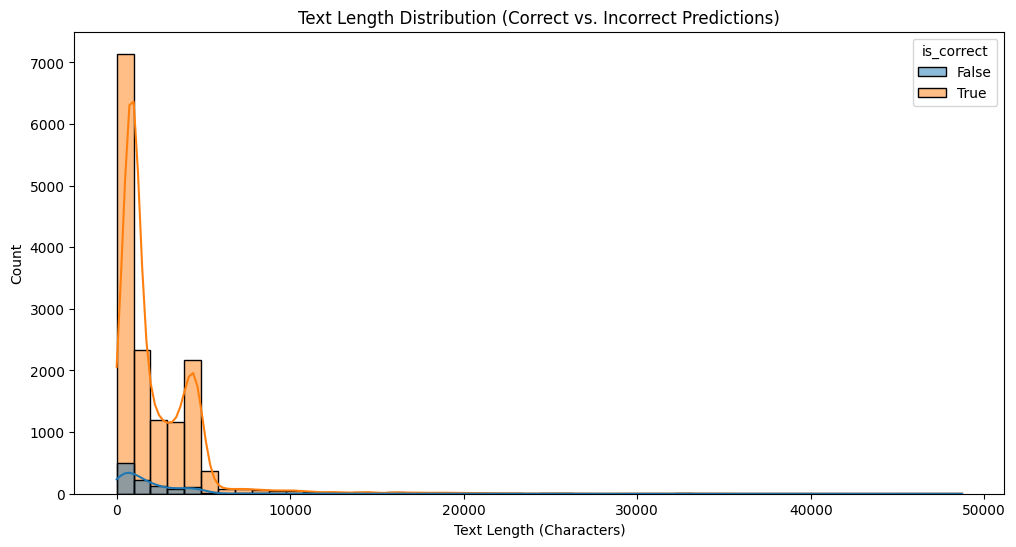

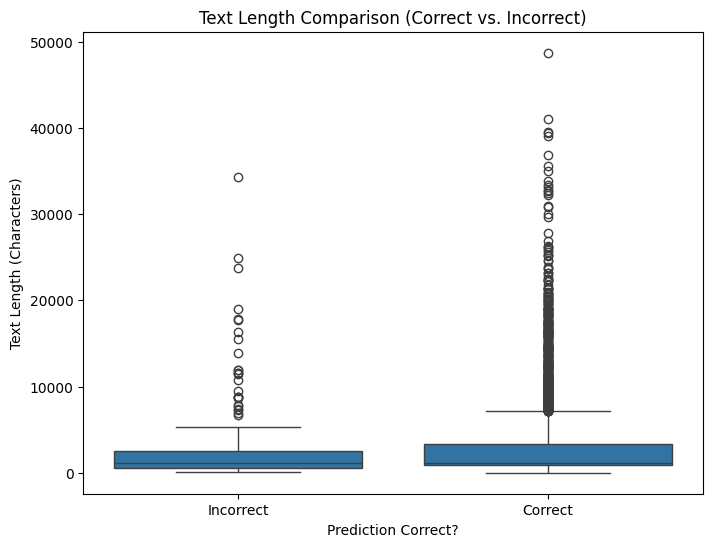

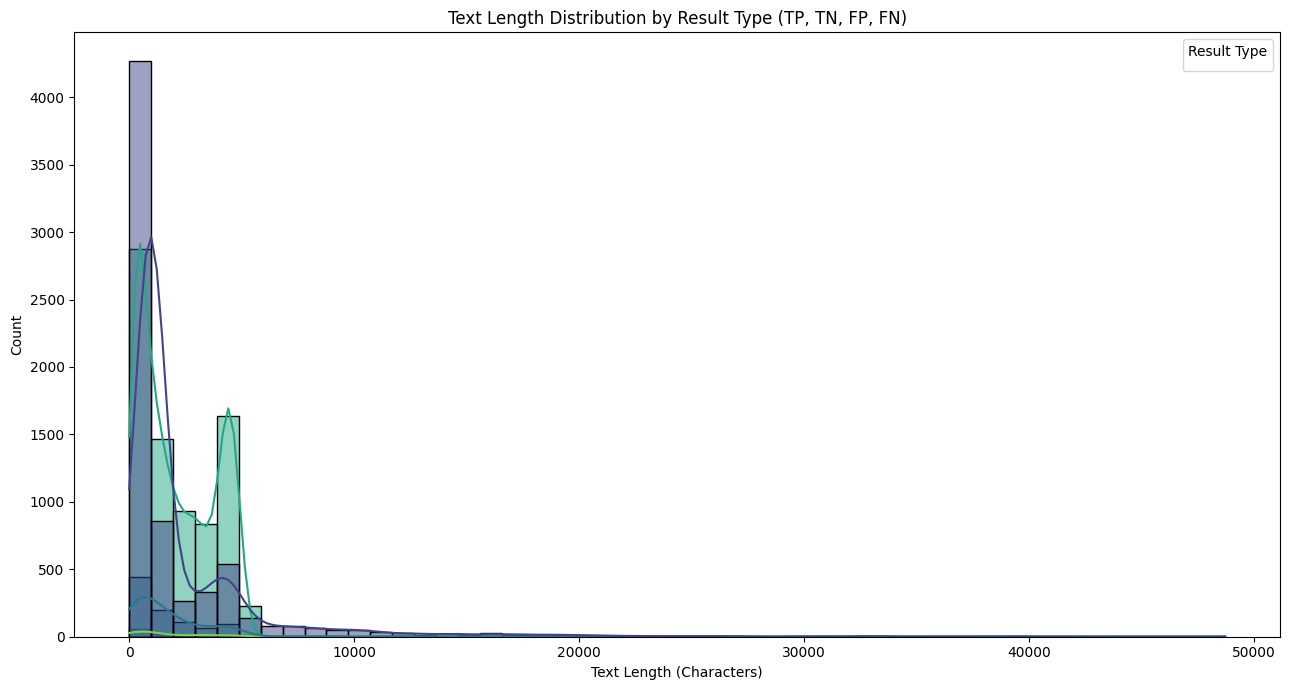

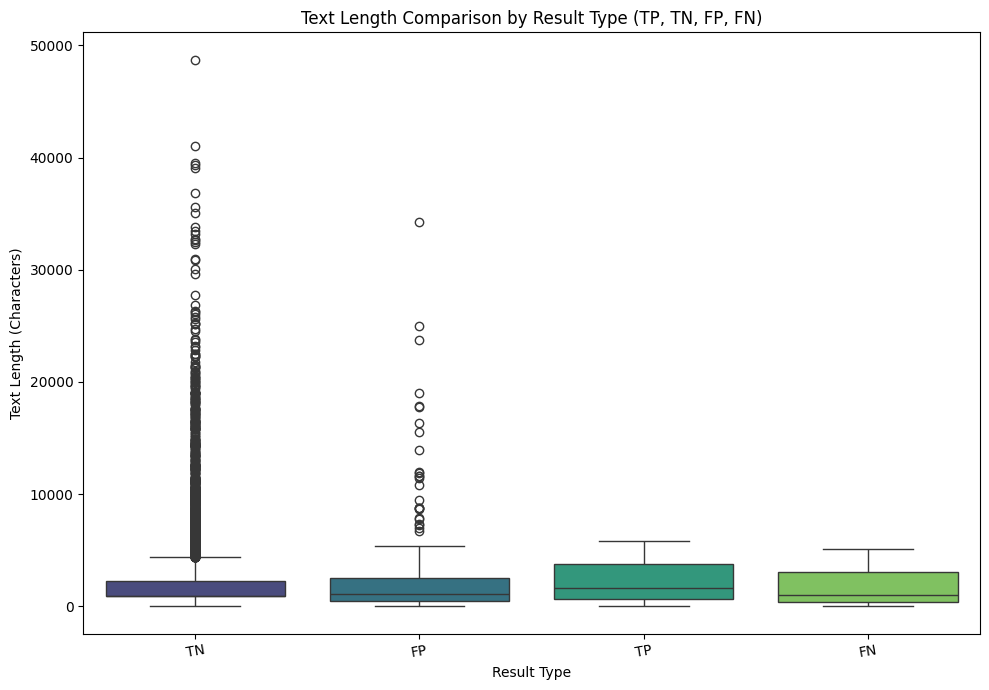


--- Analyzing Text Complexity ---


Calculating Complexity: 100%|██████████| 16000/16000 [00:15<00:00, 1014.84it/s]



Average Complexity Scores:
            difficult_words
is_correct                 
False             59.472196
True              65.831314


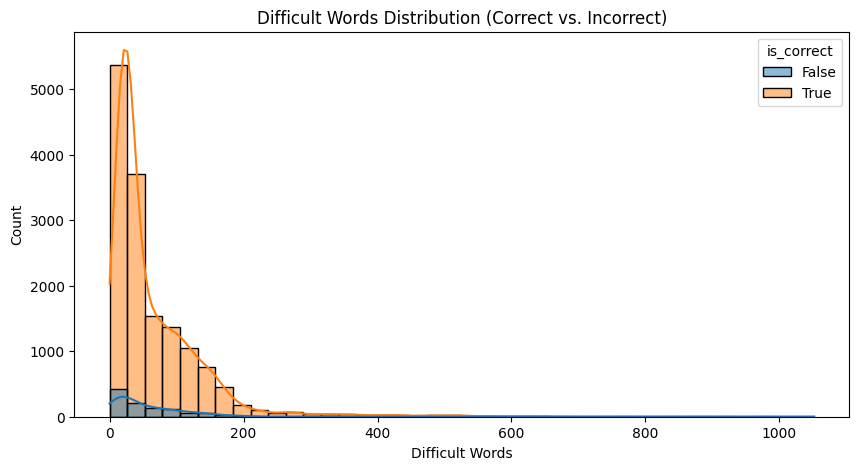


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           6970.0  72.817504  103.594408  0.0  22.0  30.0  80.00  1052.0
FP            948.0  60.224684   69.671981  0.0  16.0  39.0  85.25   772.0
TP           7969.0  59.720919   45.927620  0.0  19.0  50.0  92.00   219.0
FN            113.0  53.159292   48.813341  1.0  13.0  38.0  81.00   203.0


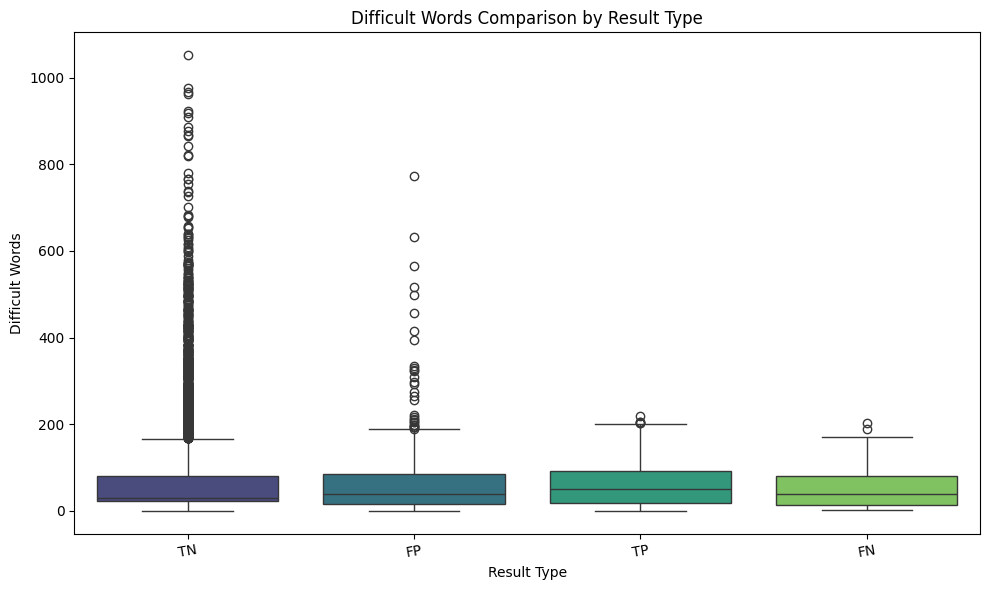

Could not generate legend for difficult_words histogram.


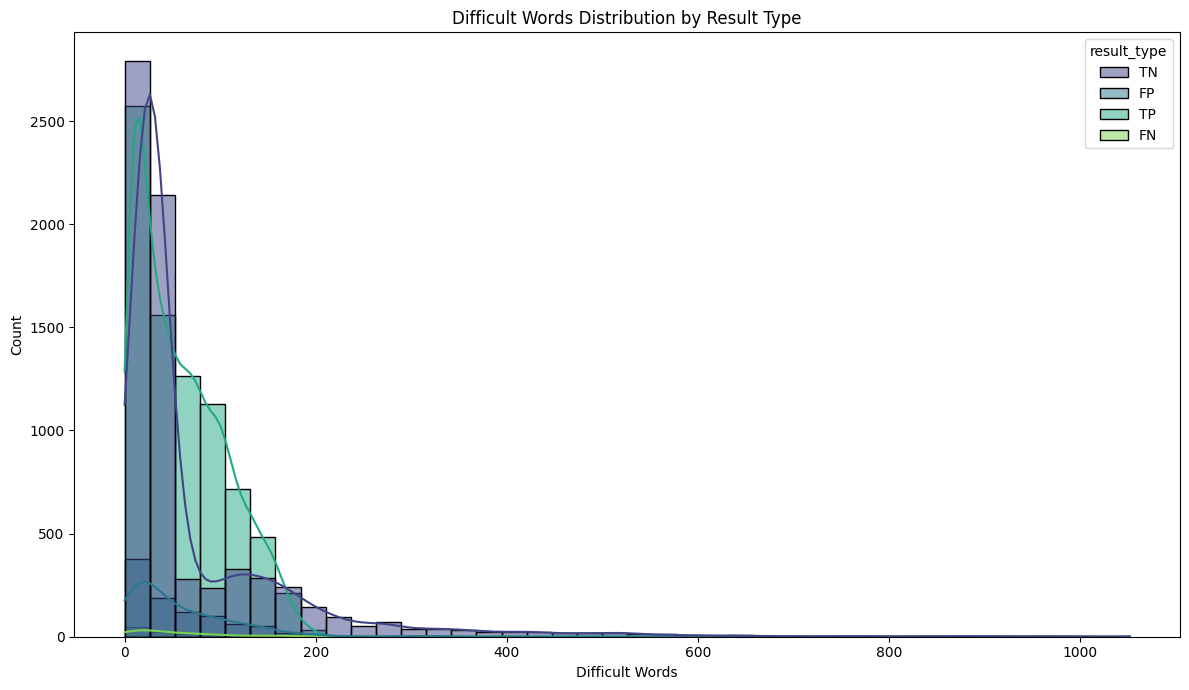


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      14426
1   people      13557
2      new      12534
3     time      10686
4     like      10069
5     just       9845
6     make       7710
7      way       6545
8      use       6432
9     know       5972
10   world       5864
11   years       5722
12    good       5257
13    dont       5245
14    work       5199
15    want       5056
16   going       5043
17    need       4913
18   think       4798
19    used       4740


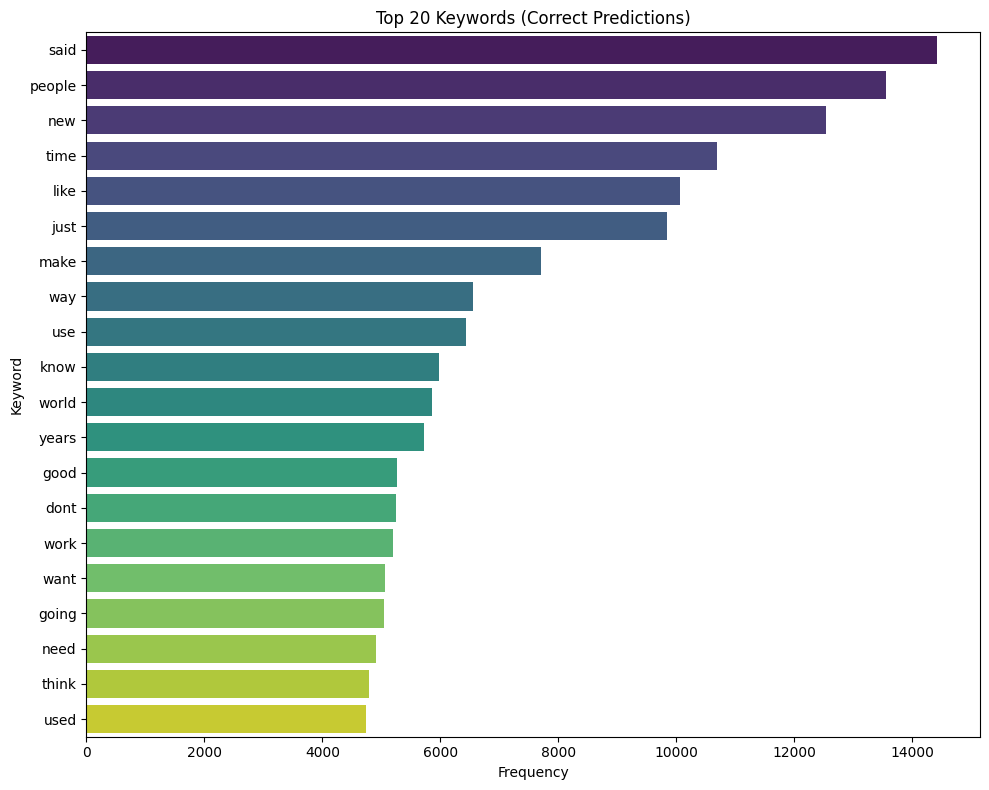


Top 20 Keywords for Incorrect Predictions:
        Keyword  Frequency
0          said       1031
1        people        712
2           new        669
3          time        536
4          like        511
5          just        491
6           use        445
7          make        406
8          year        338
9         years        335
10          way        326
11  information        319
12        world        306
13         used        299
14         team        286
15         game        281
16       police        280
17         need        279
18    according        270
19        state        266


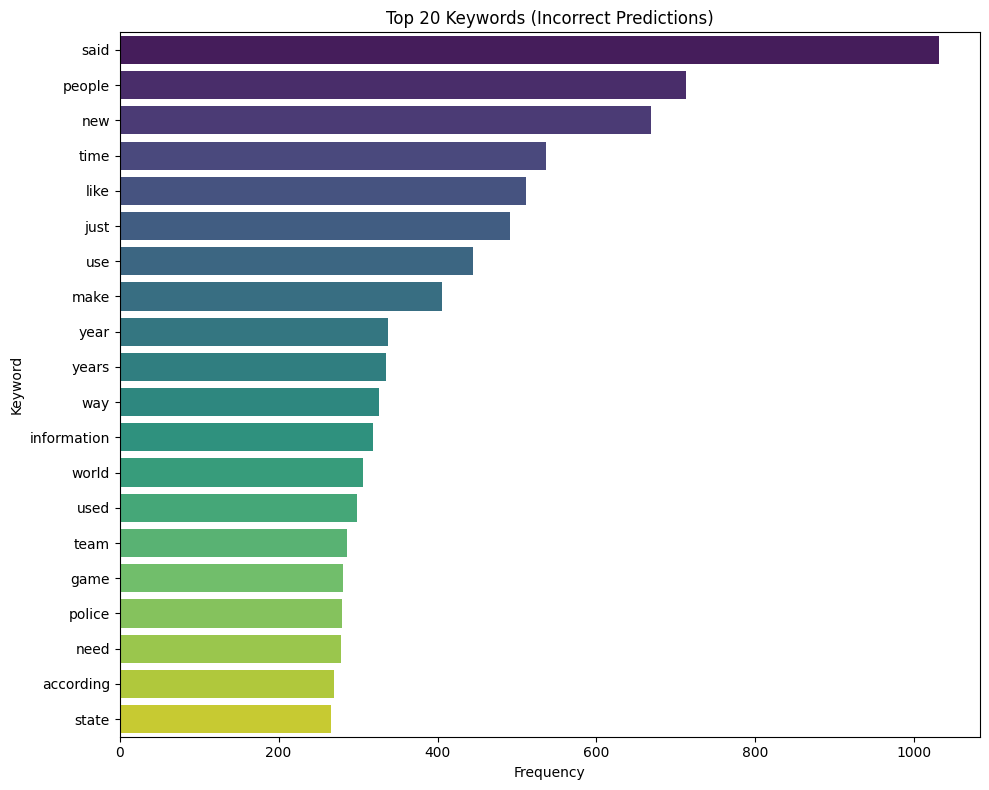


Top 20 Keywords for True Negatives:
      Keyword  Frequency
0      people       5620
1        time       5062
2        like       4670
3        just       4332
4         new       4065
5        said       3623
6       world       2999
7     company       2911
8         way       2871
9        life       2758
10        use       2691
11       know       2557
12       work       2539
13       make       2505
14      years       2436
15  different       2342
16       used       2329
17        man       2177
18        did       2163
19   business       2097


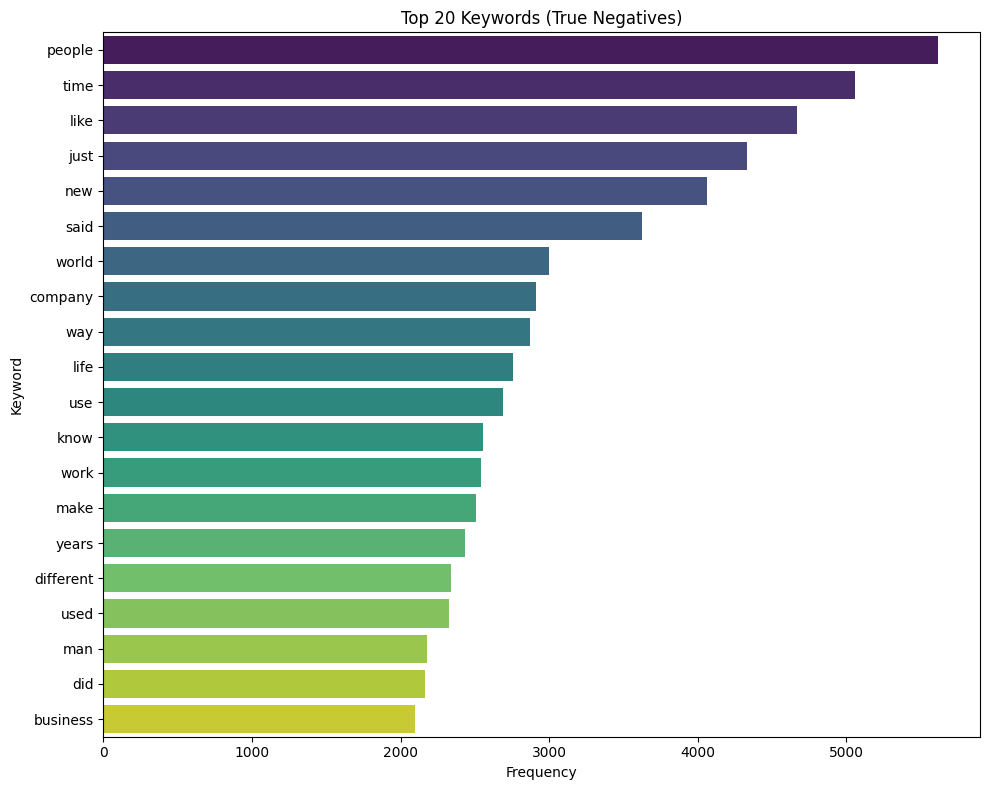


Top 20 Keywords for False Positives:
        Keyword  Frequency
0          said        957
1        people        669
2           new        607
3          time        499
4          like        468
5          just        444
6           use        406
7          make        366
8          year        316
9         years        306
10          way        297
11  information        287
12         used        281
13        world        275
14       police        261
15    according        260
16         need        259
17         food        251
18         game        249
19        state        242


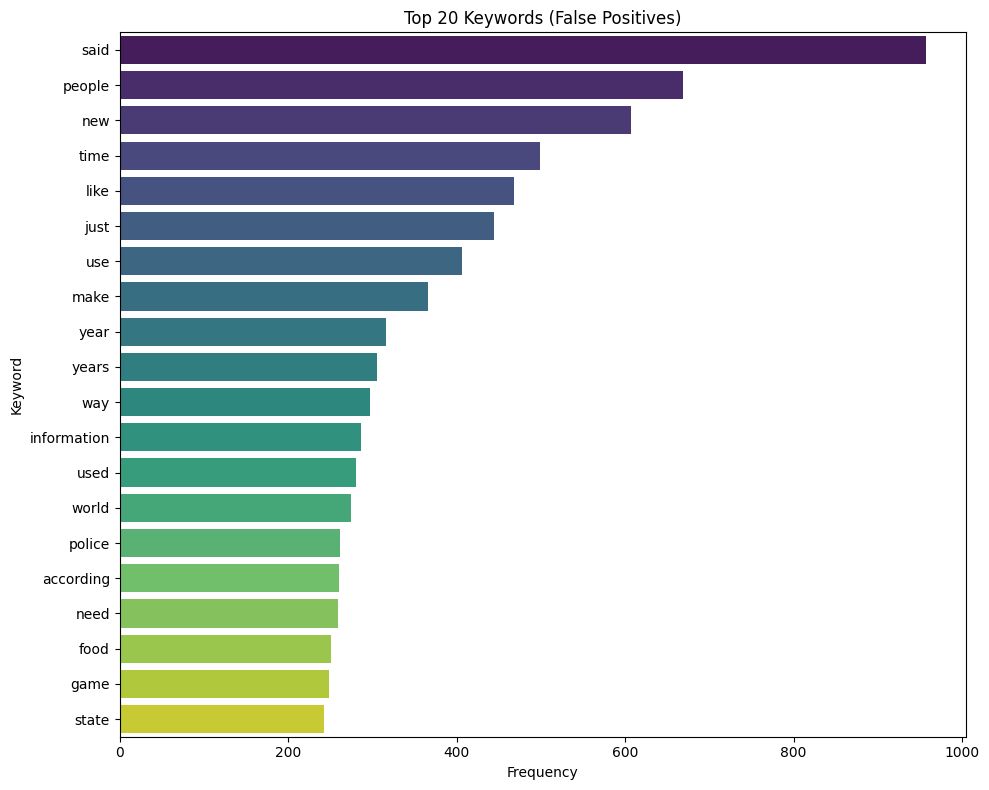


Top 20 Keywords for False Negatives:
           Keyword  Frequency
0             said         74
1              new         62
2             days         58
3          support         54
4             team         50
5             just         47
6           people         43
7             like         43
8           number         40
9             make         40
10             use         39
11            time         37
12            dont         37
13            arts         36
14  virtualization         34
15           party         33
16            game         32
17           going         32
18           great         32
19          domain         32


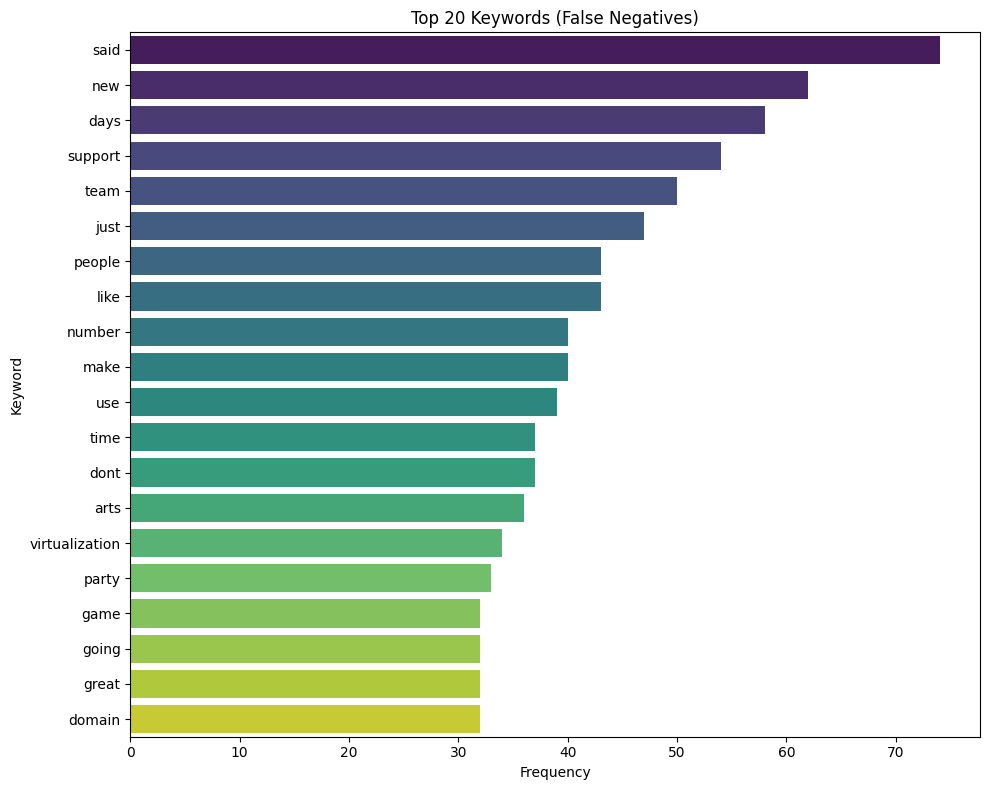


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said      10803
1          new       8469
2       people       7937
3         time       5624
4         just       5513
5         like       5399
6         make       5205
7         want       3748
8          use       3741
9          way       3674
10        dont       3490
11       going       3483
12        know       3415
13       years       3286
14       think       3267
15        good       3245
16        year       3115
17        game       3058
18        need       3008
19  government       2962


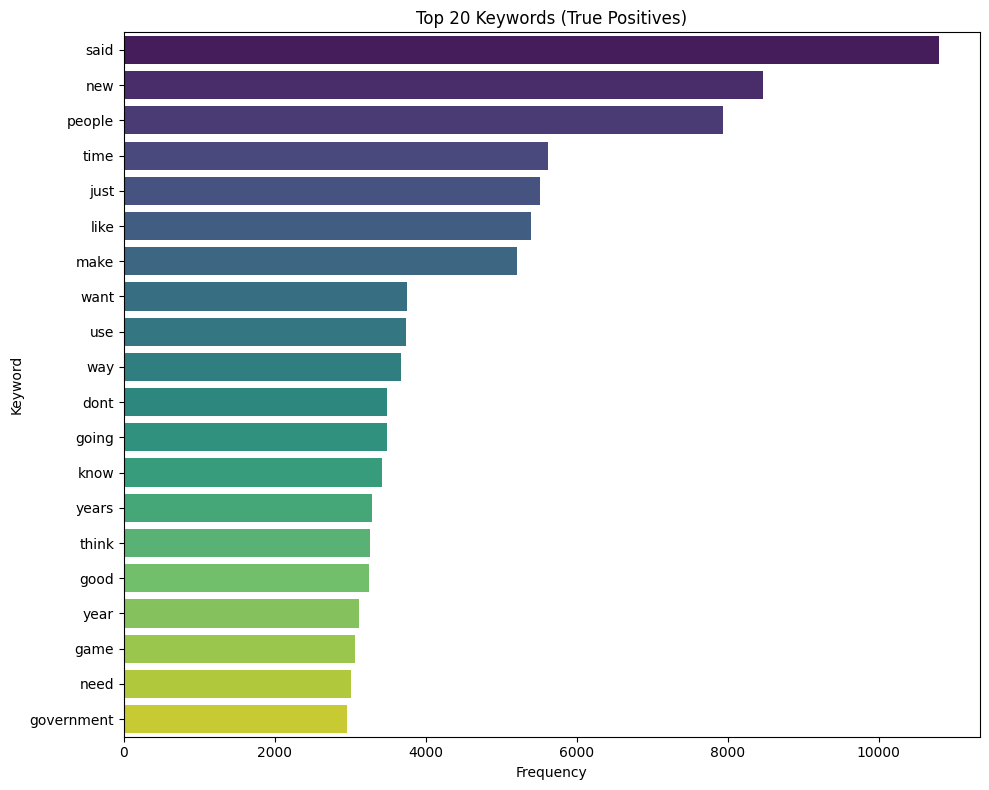


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      40895
1     in the      34003
2     to the      17453
3     on the      13703
4    and the      11131
5      to be      10710
6    for the      10265
7   that the       9659
8       in a       8442
9      it is       8403
10  with the       8187
11    at the       7825
12      is a       7590
13  from the       7205
14      of a       6826
15      as a       6270
16    by the       6140
17    it was       6052
18    is the       5178
19   will be       5005


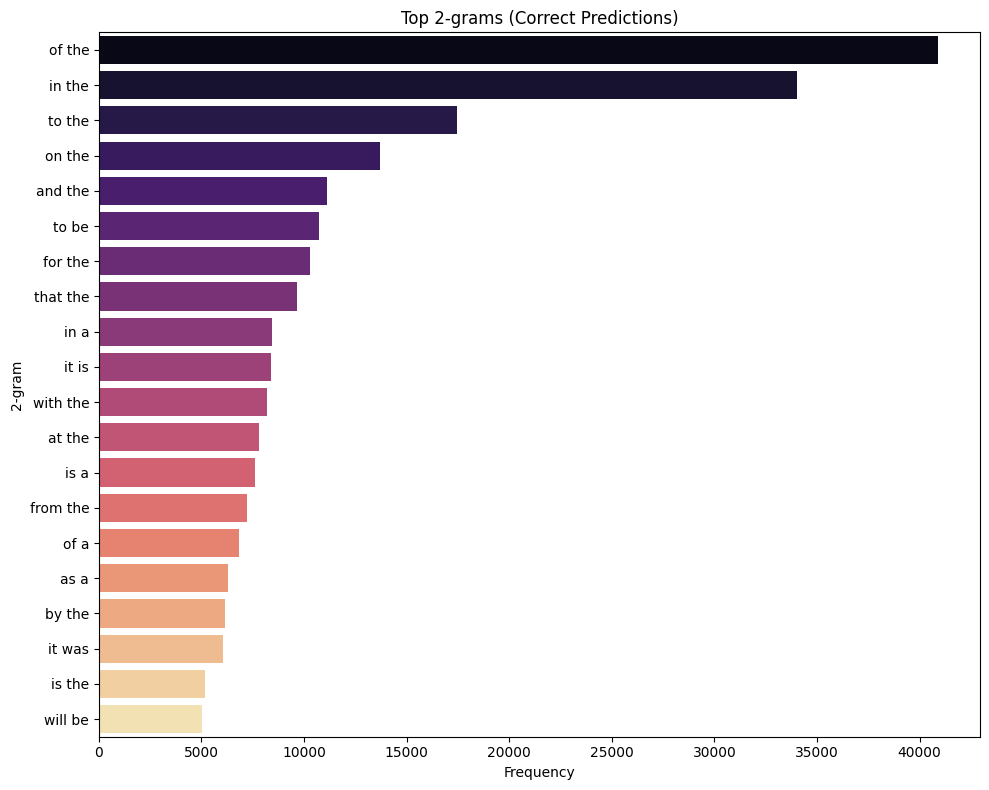


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       2554
1     in the       2048
2     to the       1043
3     on the        764
4    for the        634
5      to be        570
6    and the        567
7   that the        534
8      it is        502
9       is a        495
10  with the        489
11    at the        470
12      in a        461
13  from the        432
14    by the        407
15      of a        397
16      as a        373
17    is the        303
18   you can        298
19   this is        292


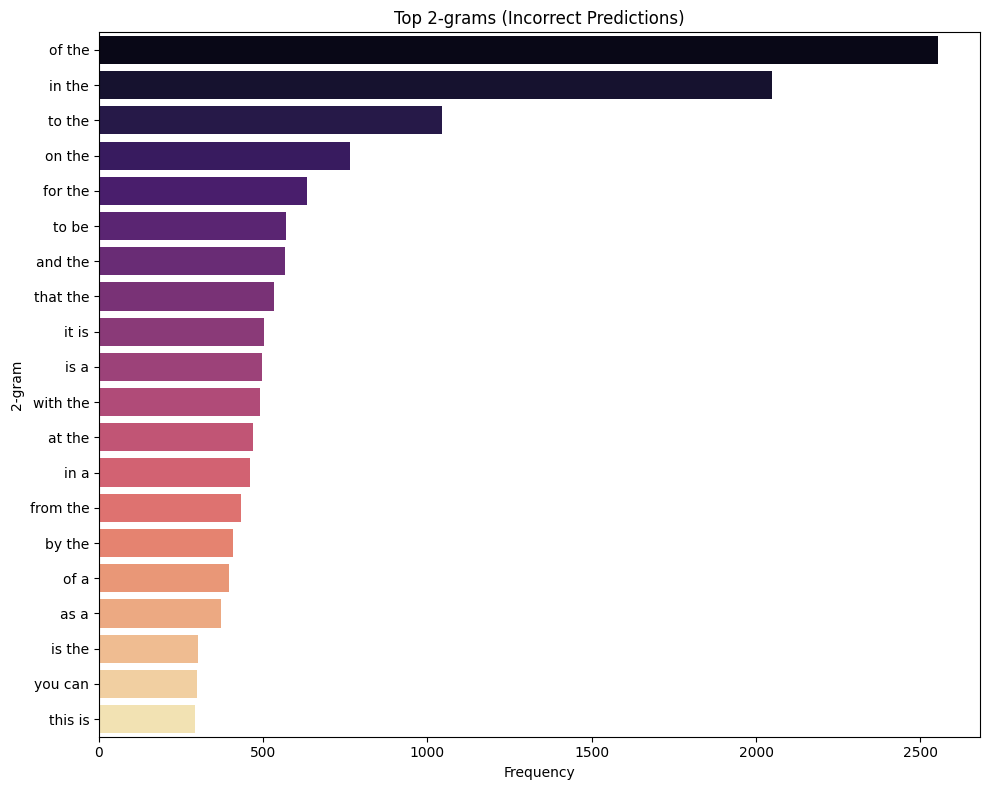

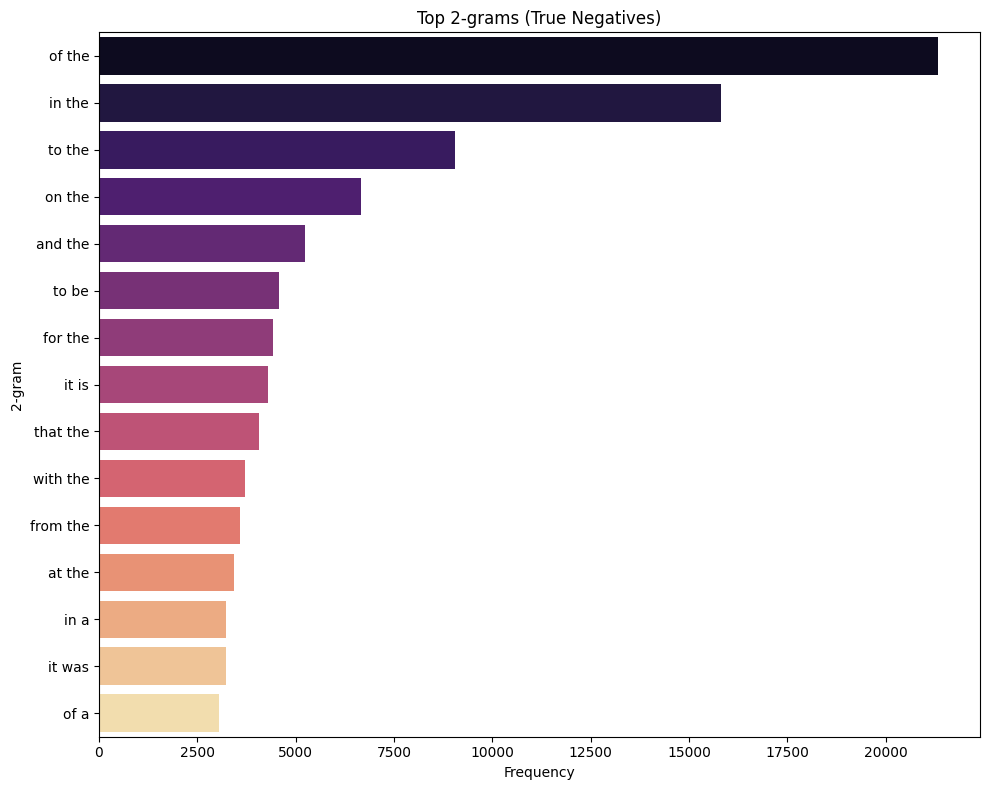

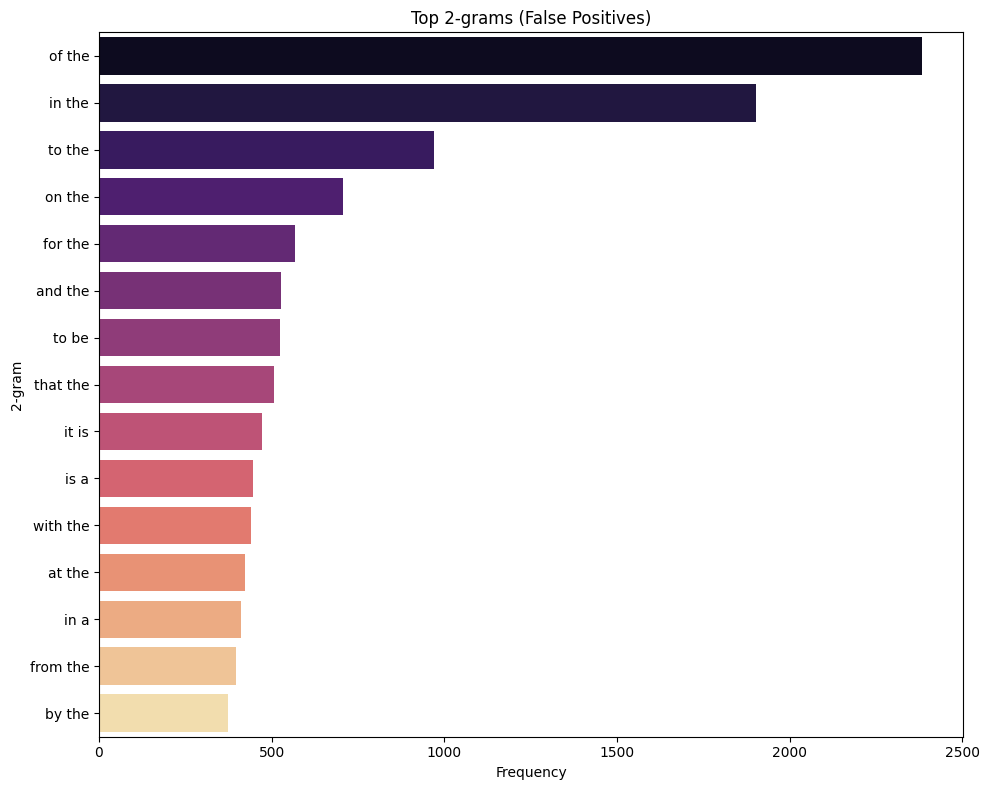

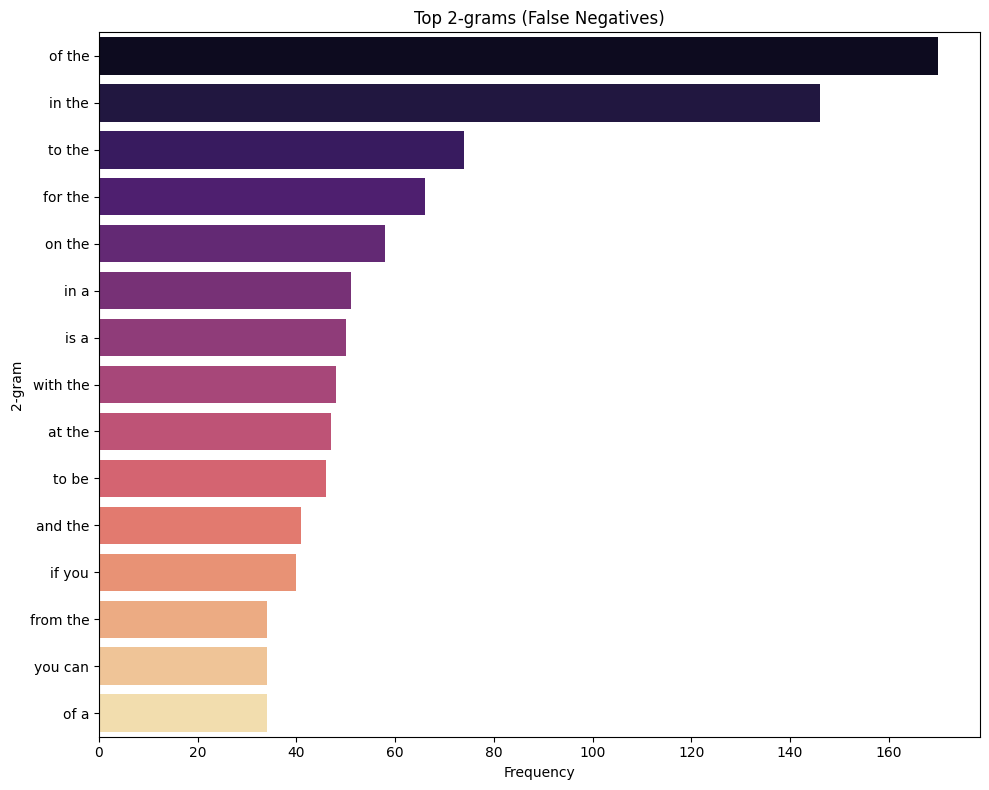

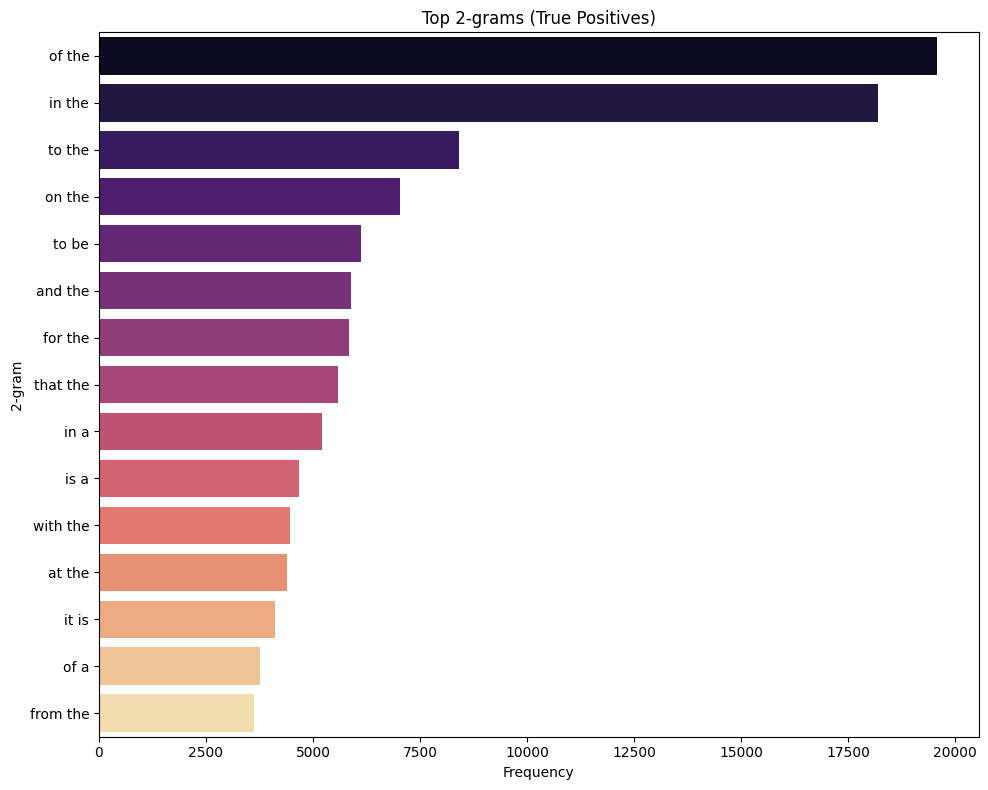


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2993
1            a lot of       2385
2   the united states       2280
3          as well as       1977
4          be able to       1528
5         in order to       1516
6       the fact that       1368
7         some of the       1263
8    according to the       1217
9             to be a       1102
10        a number of       1069
11        part of the        995
12      the number of        989
13         there is a        937
14         the end of        892
15         the use of        885
16         out of the        860
17          this is a        857
18       in the world        841
19        as a result        840


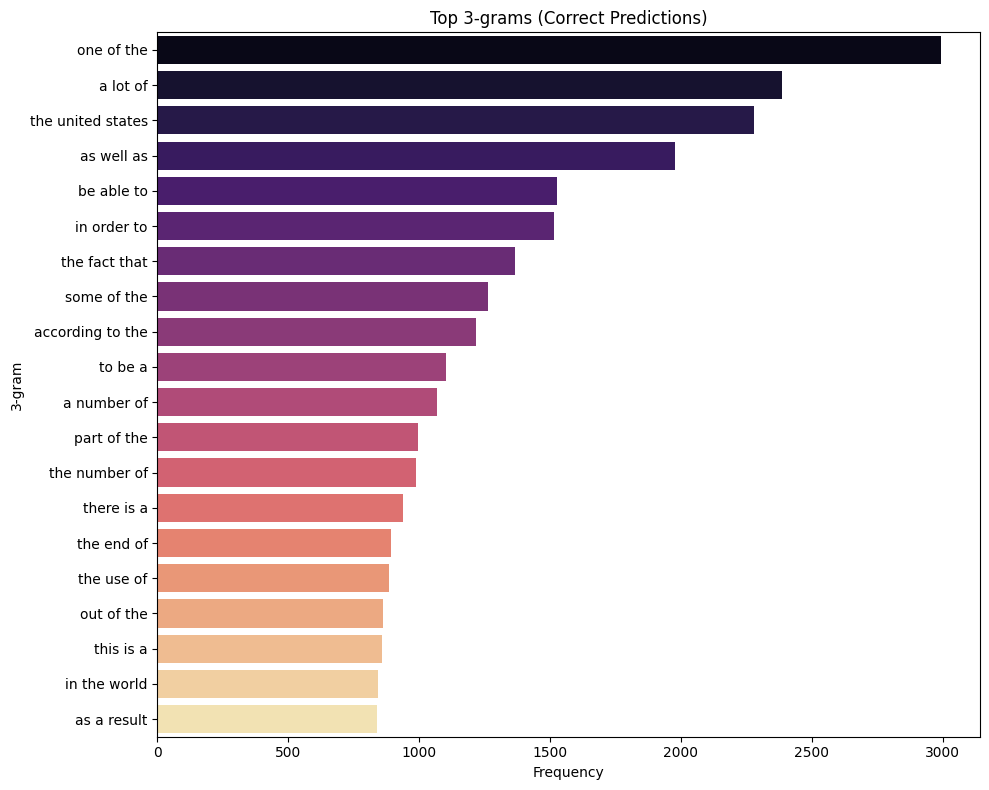


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        195
1            a lot of        132
2   the united states        120
3    according to the        110
4          as well as        104
5         some of the         85
6          be able to         81
7         in order to         77
8           this is a         72
9       the fact that         62
10       in the world         60
11        part of the         59
12        a number of         58
13         there is a         58
14         the end of         54
15      the number of         52
16        of the most         51
17          is one of         51
18          in the us         51
19        as a result         50


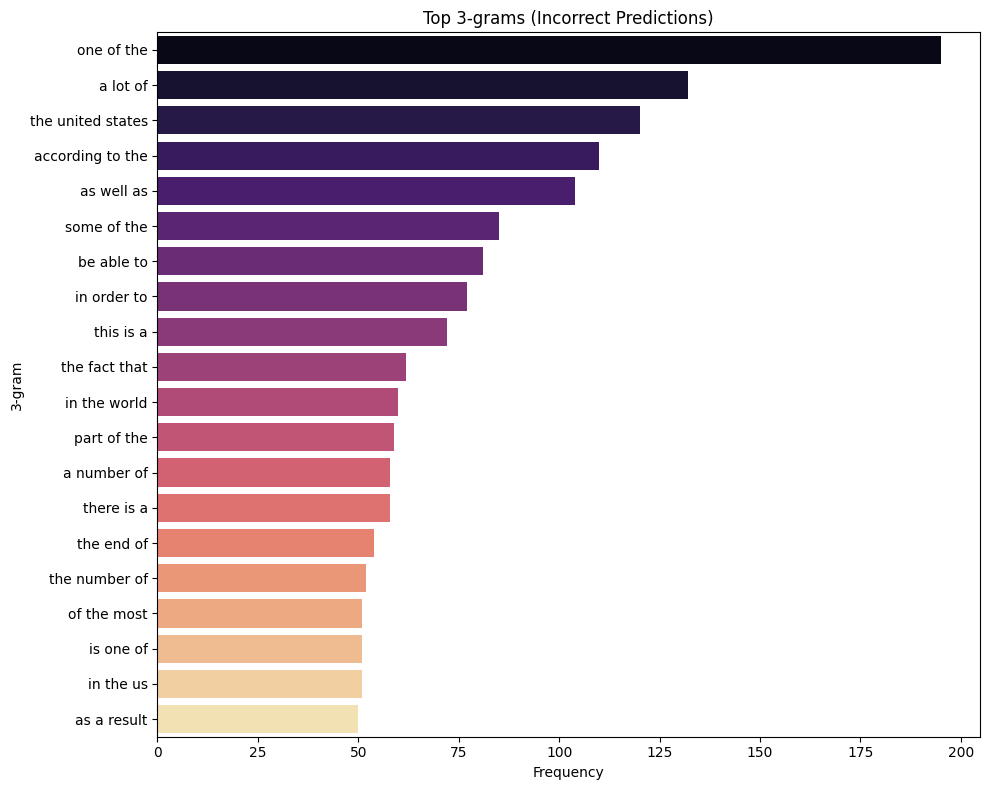

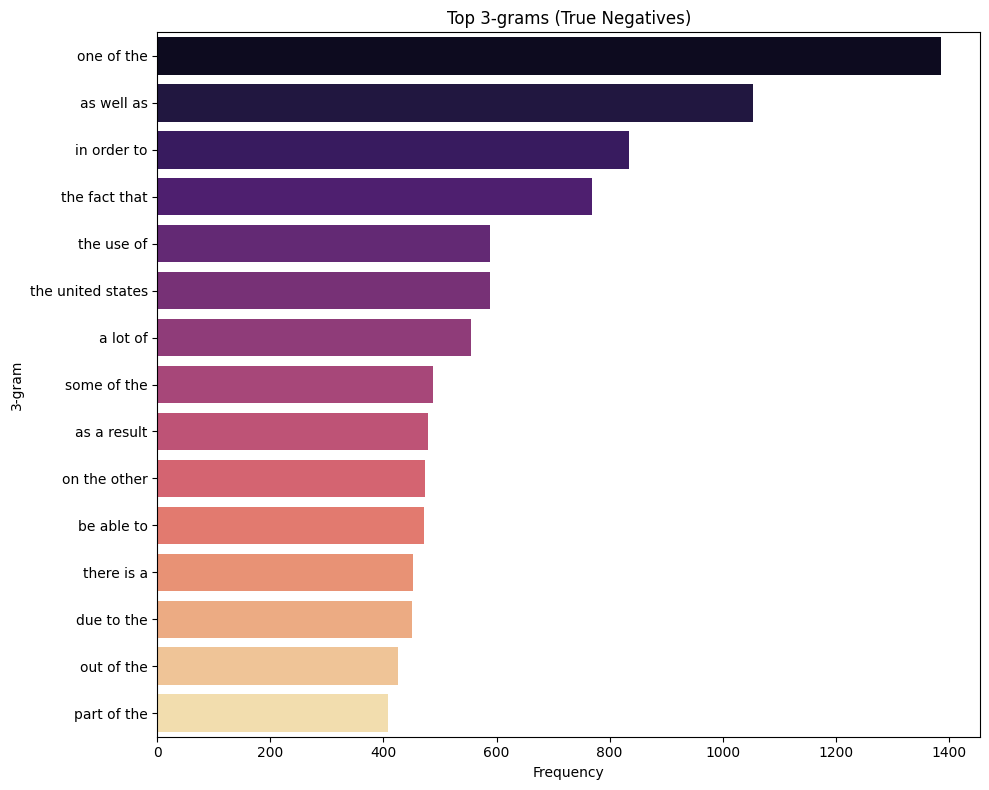

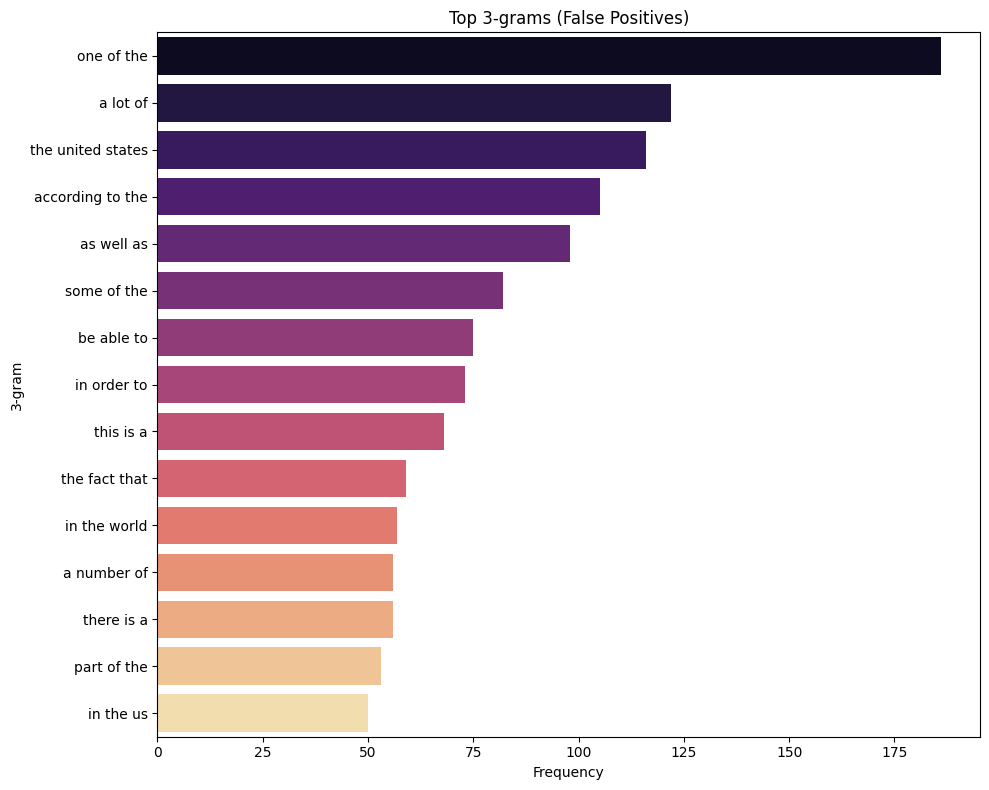

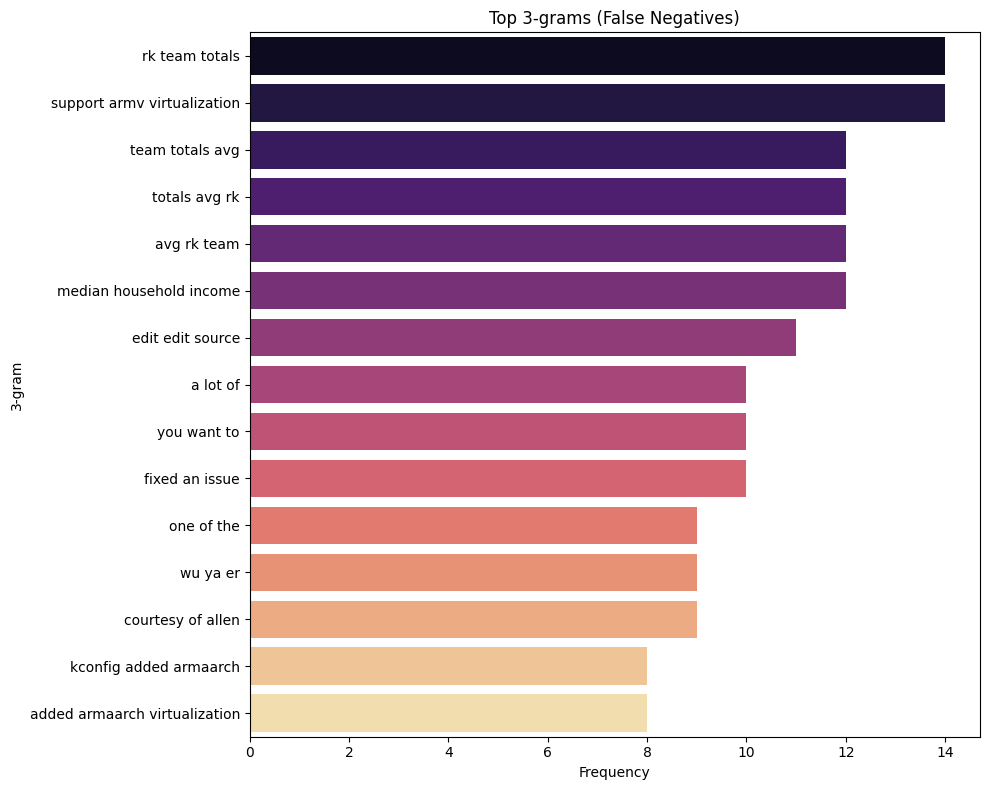

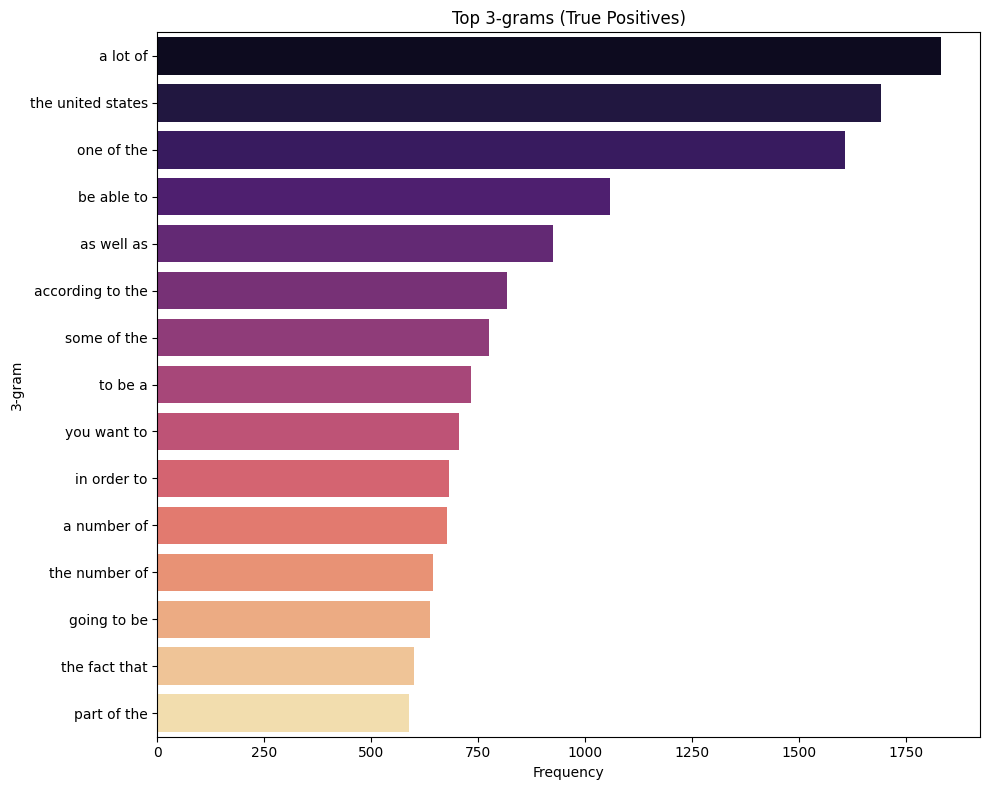


--- Analyzing Prediction Confidence ---


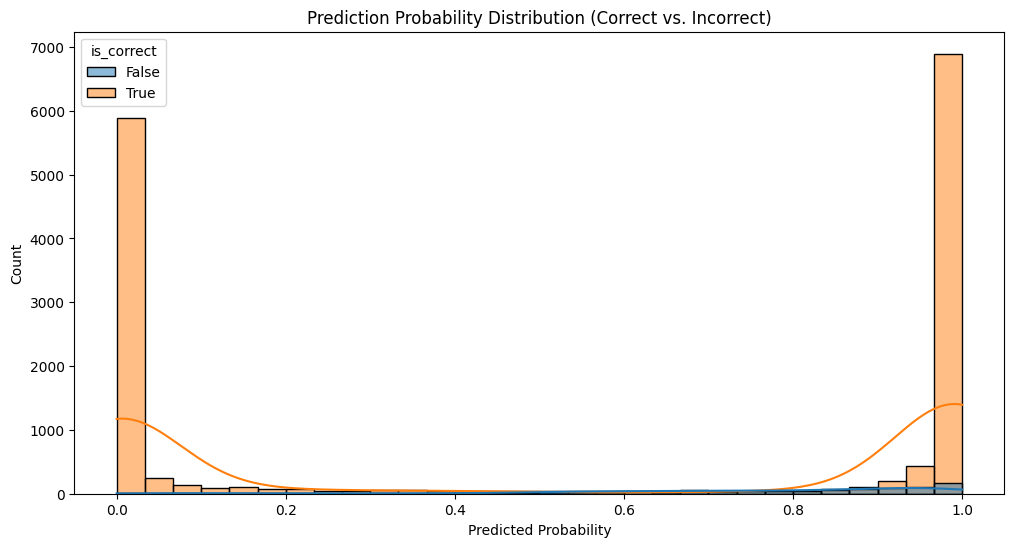


Average Prediction Probability:
is_correct
False    0.750564
True     0.537363
Name: pred_probability, dtype: float32

--- Analyzing Prediction Confidence by result type ---


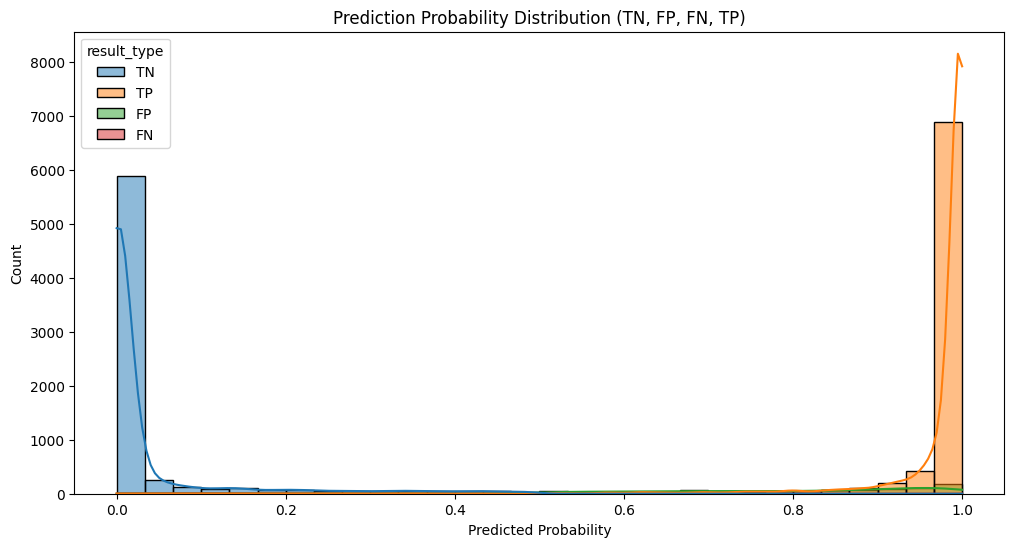


Average Prediction Probability:
result_type
FN    0.237145
FP    0.811763
TN    0.032906
TP    0.978581
Name: pred_probability, dtype: float32

--- Analyzing High-Confidence Errors Examples ---
Found 369 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 14874 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9997
  Text Snippet:     i have no idea why this is the first book i have ever read by diane stanley because this was a really fun read there were some parts that seemed a bit rushed but aside from that the book flowed very well i think that target audience readers recommended age range for this book is according to my copy would really enjoy this although the narrator is a girl i think that all readers would enjoy this book no matter their gender franny is a sensible and easy to get behind heroine the nar i have no ide...
------------------------

In [25]:
main(
    validation_data="data/text_validation.csv",
    model="finetuned_model/distilbert_lora_no_features_finetuned_detector",
    use_features="False"
)


Preparing data for model
Using device: cpu

Loading data from: data/text_validation.csv
Loaded 16000 samples.
Label distribution:
label
1    8082
0    7918
Name: count, dtype: int64

Extracting linguistic features...


Extracting Features: 100%|██████████| 16000/16000 [00:31<00:00, 515.41it/s]


Extracted 8 features: ['flesch_reading_ease', 'flesch_kincaid_grade', 'smog_index', 'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog', 'text_standard']

Loading pre-fitted scaler from processed_distilbert_data/feature_scaler.joblib...
Scaler loaded successfully.
Scaling features...

Loading model and tokenizer from: finetuned_model/distilbert_lora_with_features_finetuned_detector
Tokenizer loaded successfully.
Attempting to load LoRA adapter from: finetuned_model/distilbert_lora_with_features_finetuned_detector\final_lora_adapter


Some weights of DistilBertWithFeatures were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom base model 'DistilBertWithFeatures' loaded with 8 features.
LoRA adapter loaded successfully.

Preprocessing validation data for prediction...
Tokenization complete.
DataLoader created.

Running inference...


Predicting: 100%|██████████| 1000/1000 [47:19<00:00,  2.84s/it]


Predictions finished.
Prediction results combined. Counts:
result_type
TP    7931
TN    7093
FP     825
FN     151
Name: count, dtype: int64
Accuracy: 0.9390

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7918
           1       0.91      0.98      0.94      8082

    accuracy                           0.94     16000
   macro avg       0.94      0.94      0.94     16000
weighted avg       0.94      0.94      0.94     16000


Confusion Matrix:
[[7093  825]
 [ 151 7931]]

Running error analysis for model

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    15024.000000
mean      2265.124800
std       2798.550738
min          5.000000
25%        884.000000
50%       1101.000000
75%       3405.750000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count      976.000000
mean      1662.792008
std       1868.059140
min         38.0

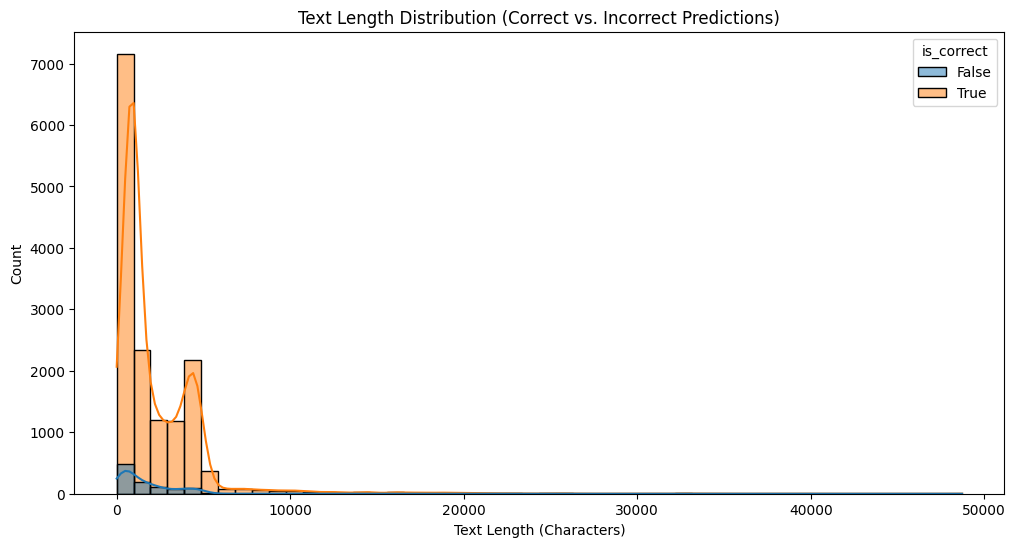

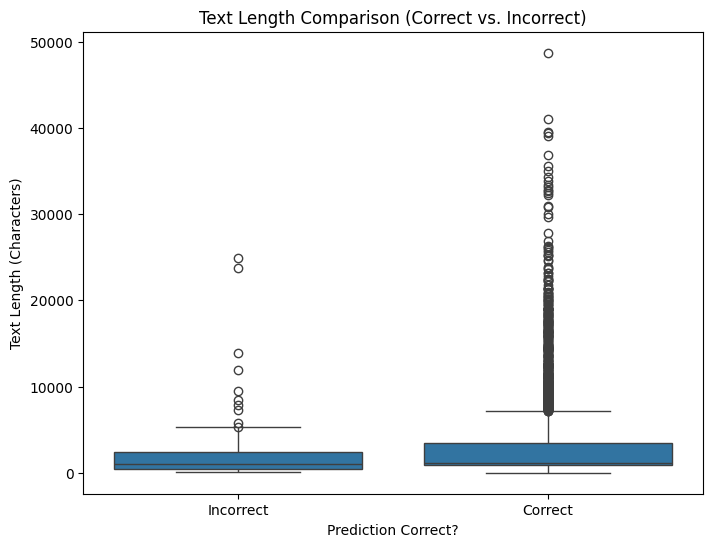

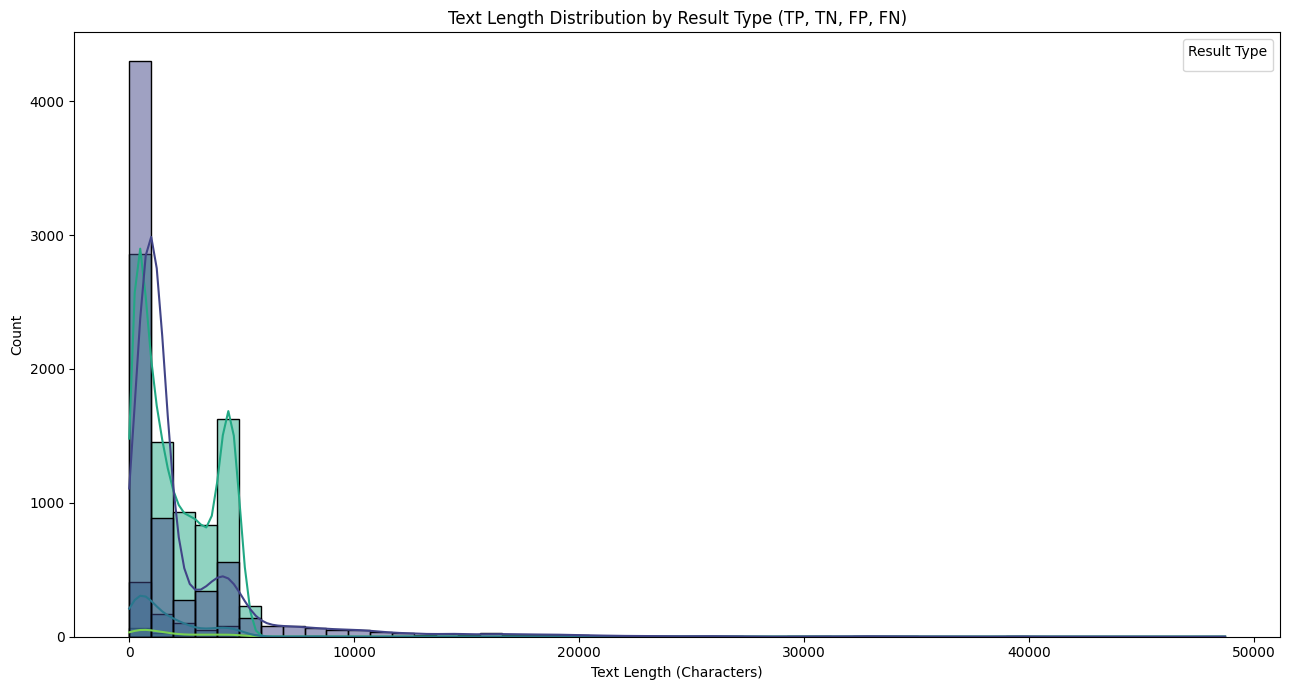

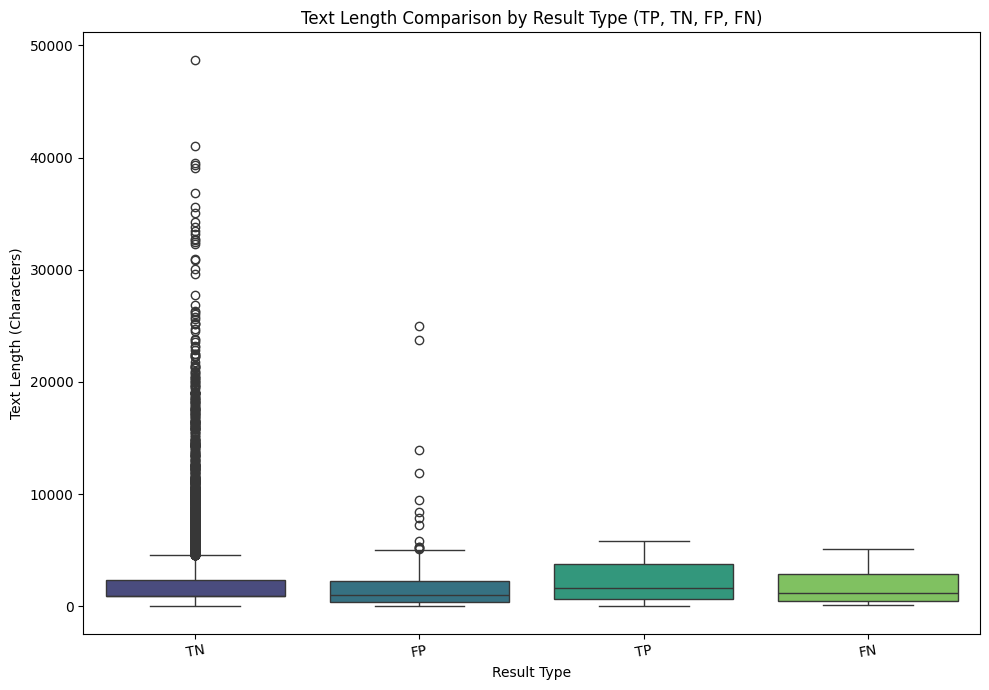


--- Analyzing Text Complexity ---


Calculating Complexity: 100%|██████████| 16000/16000 [00:25<00:00, 619.65it/s]



Average Complexity Scores:
            difficult_words
is_correct                 
False             53.280738
True              66.197551


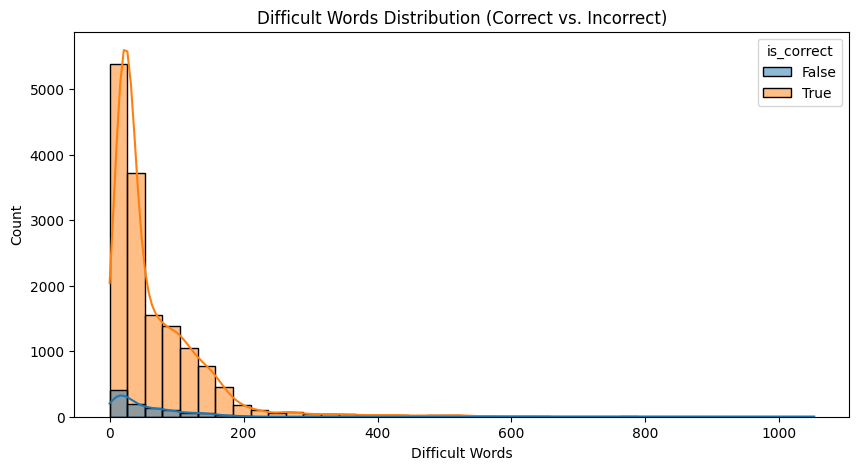


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%   75%     max
result_type                                                              
TN           7093.0  73.432257  103.969214  0.0  22.0  30.0  85.0  1052.0
FP            825.0  53.061818   55.638808  0.0  14.0  34.0  79.0   633.0
TP           7931.0  59.727273   45.950575  0.0  19.0  50.0  92.0   219.0
FN            151.0  54.476821   46.975857  2.0  19.0  39.0  76.5   203.0


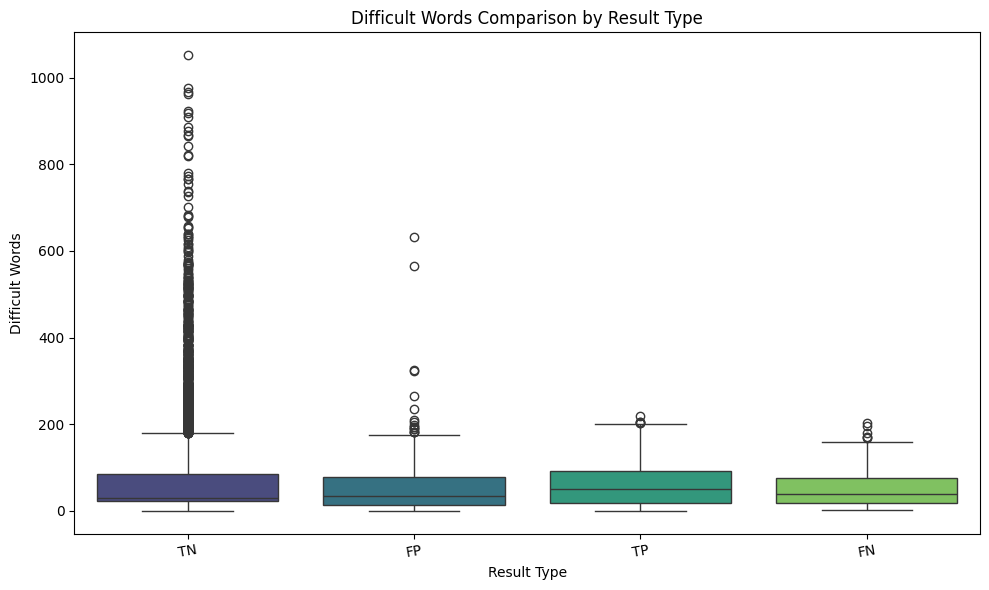

Could not generate legend for difficult_words histogram.


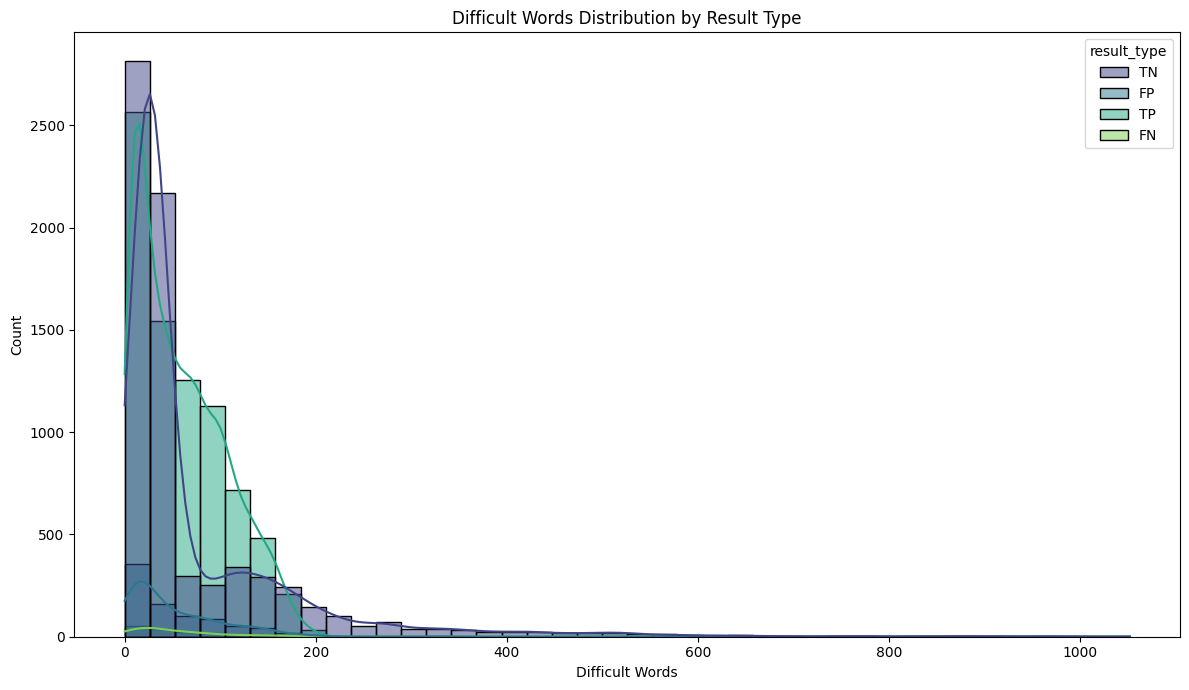


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      14565
1   people      13698
2      new      12628
3     time      10783
4     like      10163
5     just       9905
6     make       7786
7      way       6613
8      use       6543
9     know       6011
10   world       5942
11   years       5781
12    good       5324
13    dont       5261
14    work       5250
15   going       5083
16    want       5082
17    need       4981
18   think       4848
19    used       4836


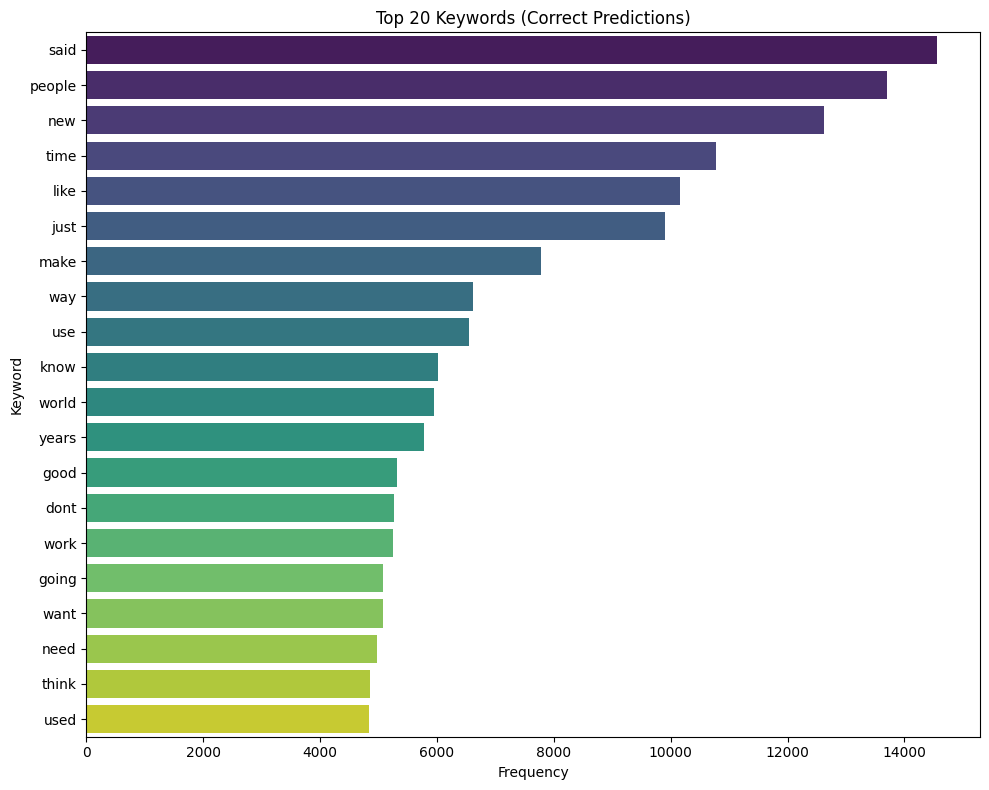


Top 20 Keywords for Incorrect Predictions:
        Keyword  Frequency
0          said        892
1           new        575
2        people        571
3          time        439
4          just        431
5          like        417
6           use        334
7          make        330
8          game        295
9          year        285
10  information        280
11       police        279
12        years        276
13          way        258
14         team        243
15        world        228
16         dont        228
17         want        226
18        group        212
19         need        211


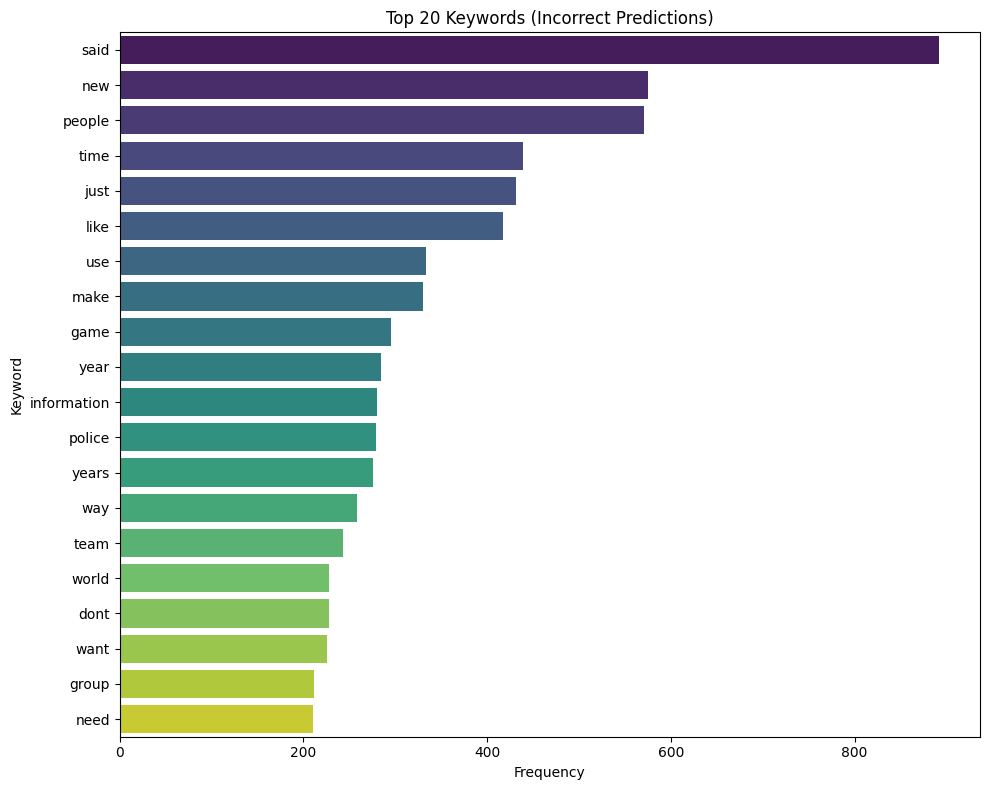


Top 20 Keywords for True Negatives:
      Keyword  Frequency
0      people       5789
1        time       5189
2        like       4781
3        just       4417
4         new       4197
5        said       3786
6       world       3096
7     company       3008
8         way       2946
9         use       2818
10       life       2792
11       know       2610
12       work       2598
13       make       2595
14      years       2502
15       used       2432
16  different       2397
17        did       2227
18        man       2207
19   business       2186


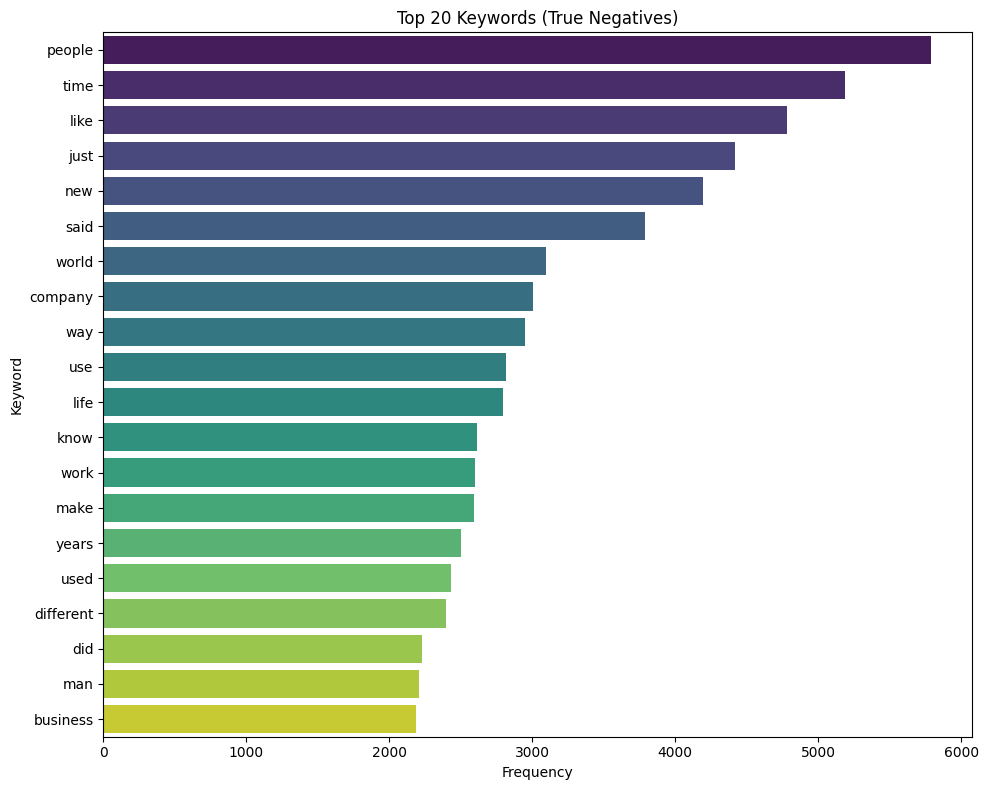


Top 20 Keywords for False Positives:
        Keyword  Frequency
0          said        794
1        people        500
2           new        475
3          time        372
4          just        359
5          like        357
6           use        279
7          make        276
8          game        255
9          year        253
10        years        240
11  information        233
12       police        225
13          way        222
14         team        201
15        group        195
16         want        191
17         dont        180
18        world        178
19         used        178


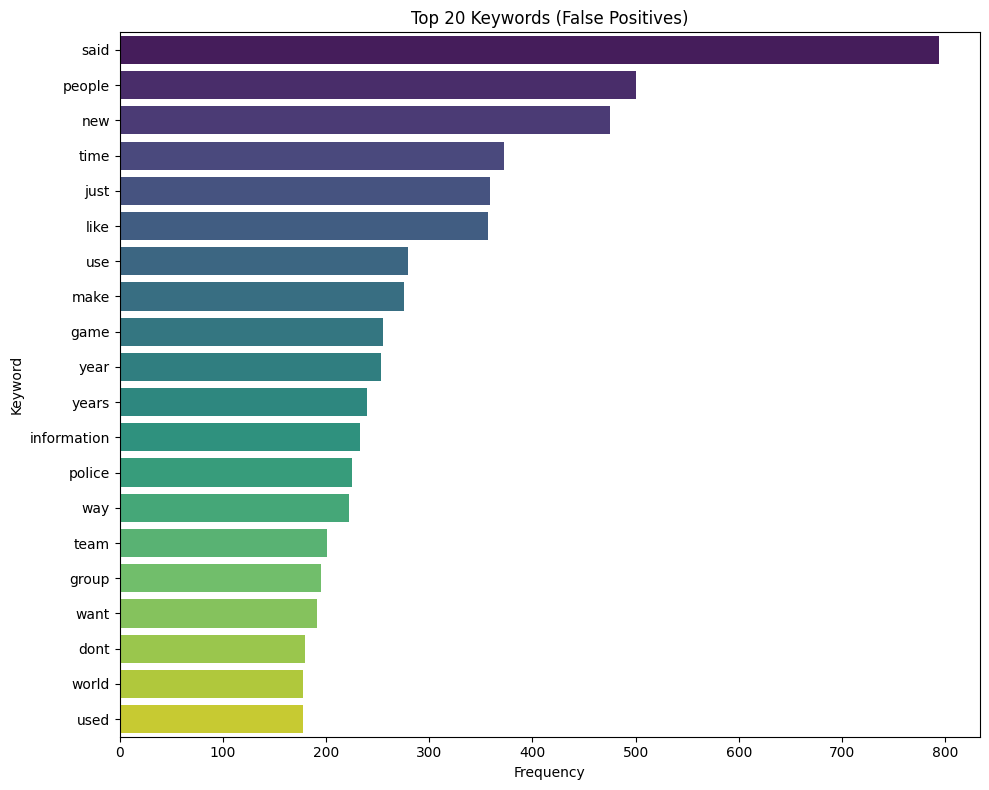


Top 20 Keywords for False Negatives:
        Keyword  Frequency
0           new        100
1          said         98
2           man         94
3          jack         76
4          just         72
5        people         71
6          time         67
7          days         63
8          like         60
9           use         55
10         make         54
11       police         54
12      support         53
13        world         50
14         dont         48
15  information         47
16        party         44
17         team         42
18         game         40
19       number         40


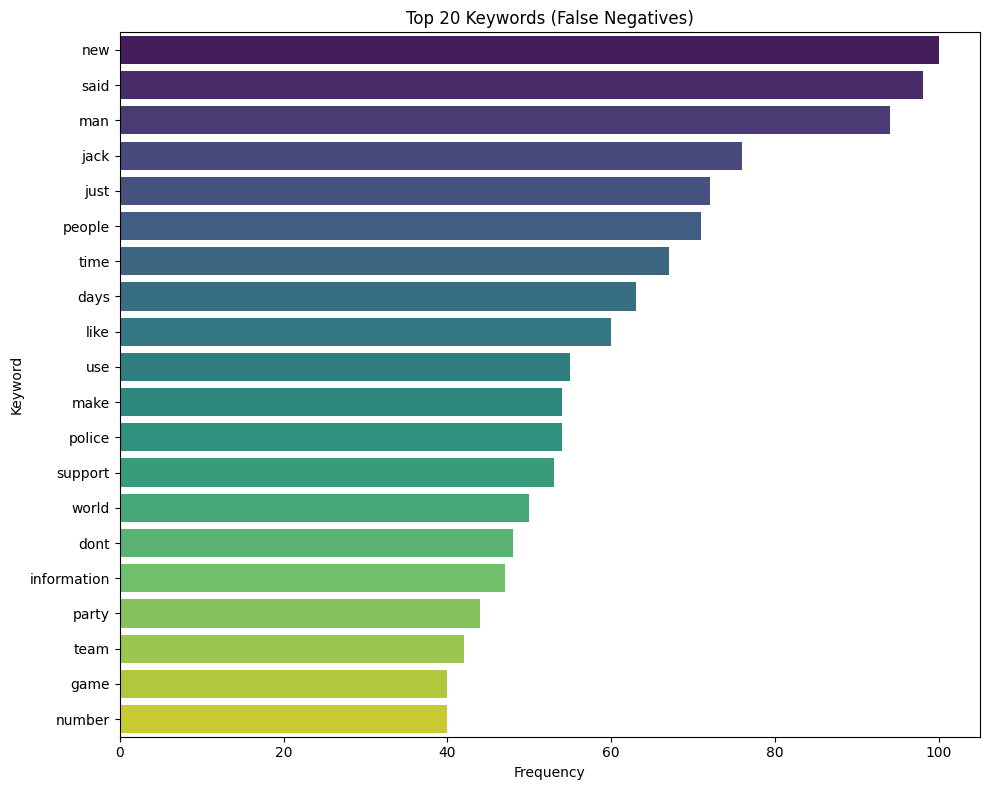


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said      10779
1          new       8431
2       people       7909
3         time       5594
4         just       5488
5         like       5382
6         make       5191
7         want       3740
8          use       3725
9          way       3667
10       going       3480
11        dont       3479
12        know       3401
13       years       3279
14       think       3263
15        good       3236
16        year       3105
17        game       3050
18        need       2994
19  government       2962


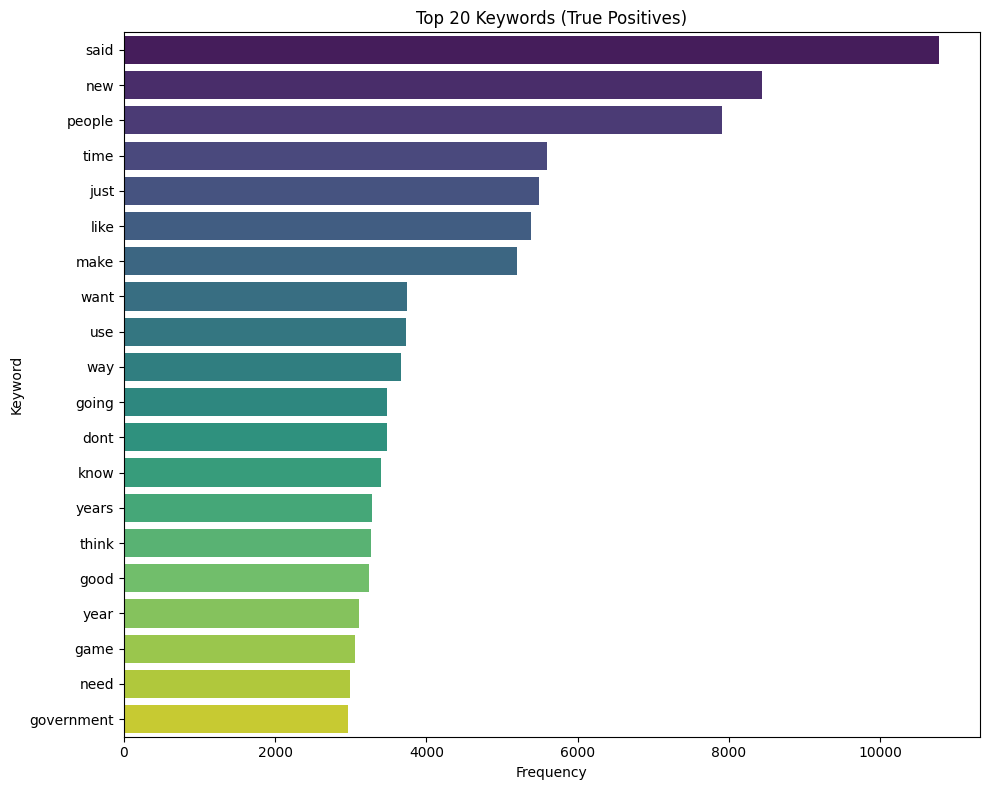


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      41672
1     in the      34498
2     to the      17736
3     on the      13853
4    and the      11271
5      to be      10828
6    for the      10397
7   that the       9839
8      it is       8547
9       in a       8495
10  with the       8287
11    at the       7896
12      is a       7682
13  from the       7297
14      of a       6919
15      as a       6378
16    by the       6246
17    it was       6078
18    is the       5264
19   will be       5095


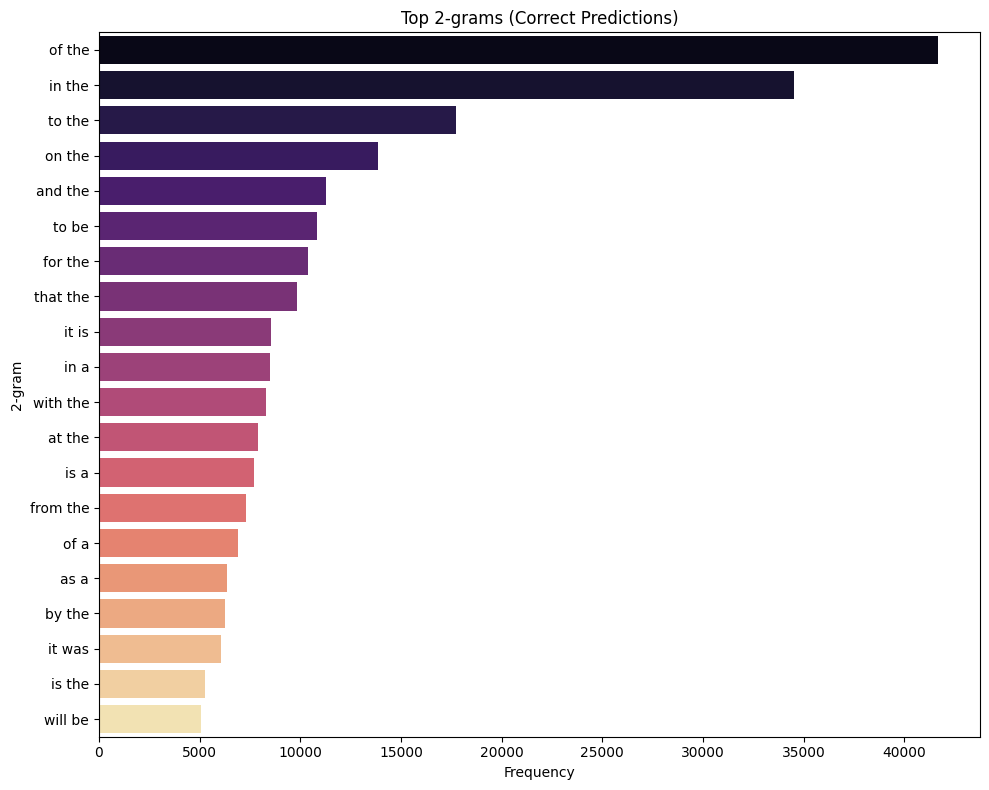


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       1777
1     in the       1553
2     to the        760
3     on the        614
4    for the        502
5      to be        452
6    and the        427
7       in a        408
8       is a        403
9     at the        399
10  with the        389
11     it is        358
12  that the        354
13  from the        340
14      of a        304
15    by the        301
16   you can        275
17      as a        265
18    with a        265
19   this is        246


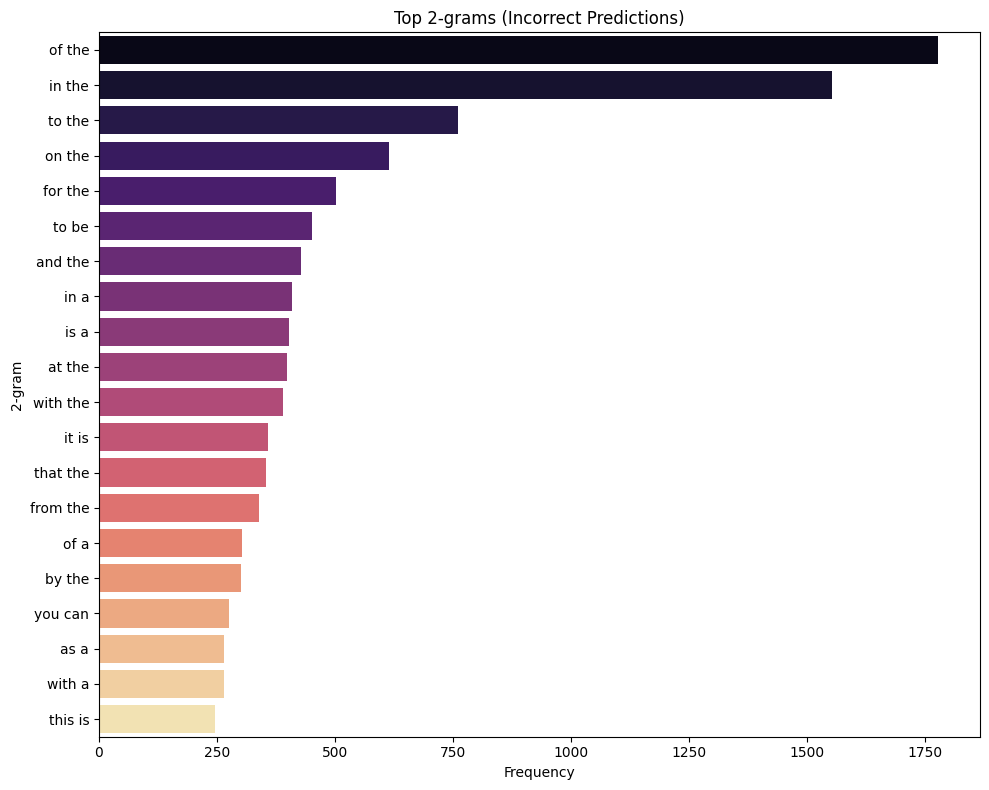

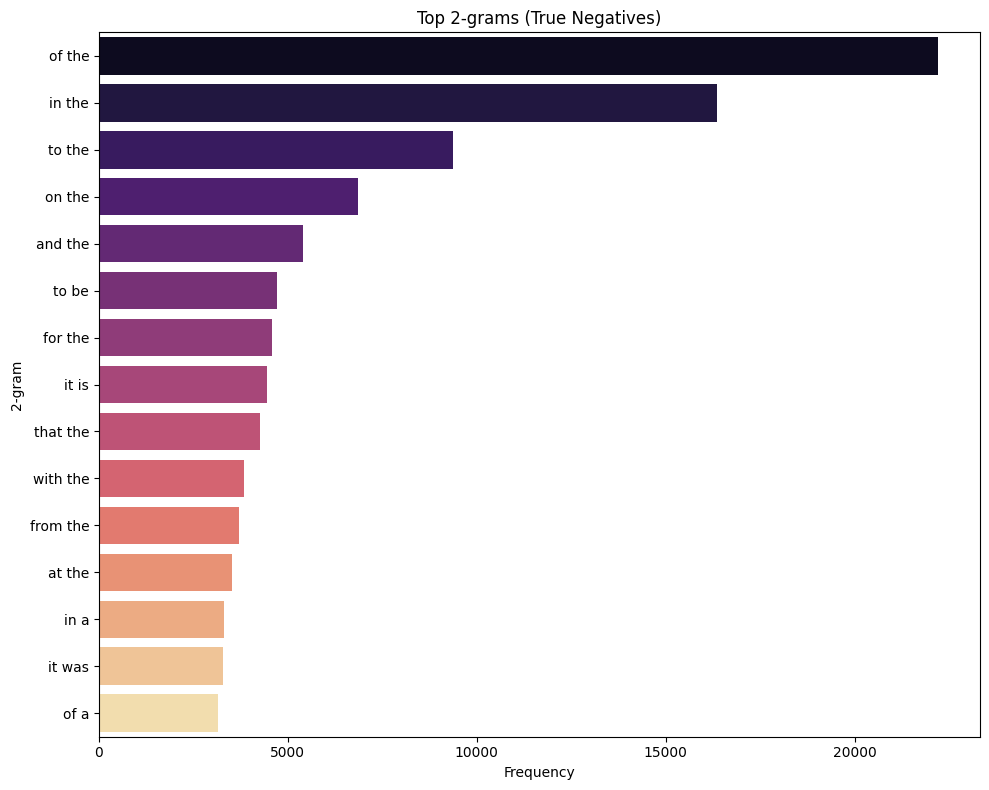

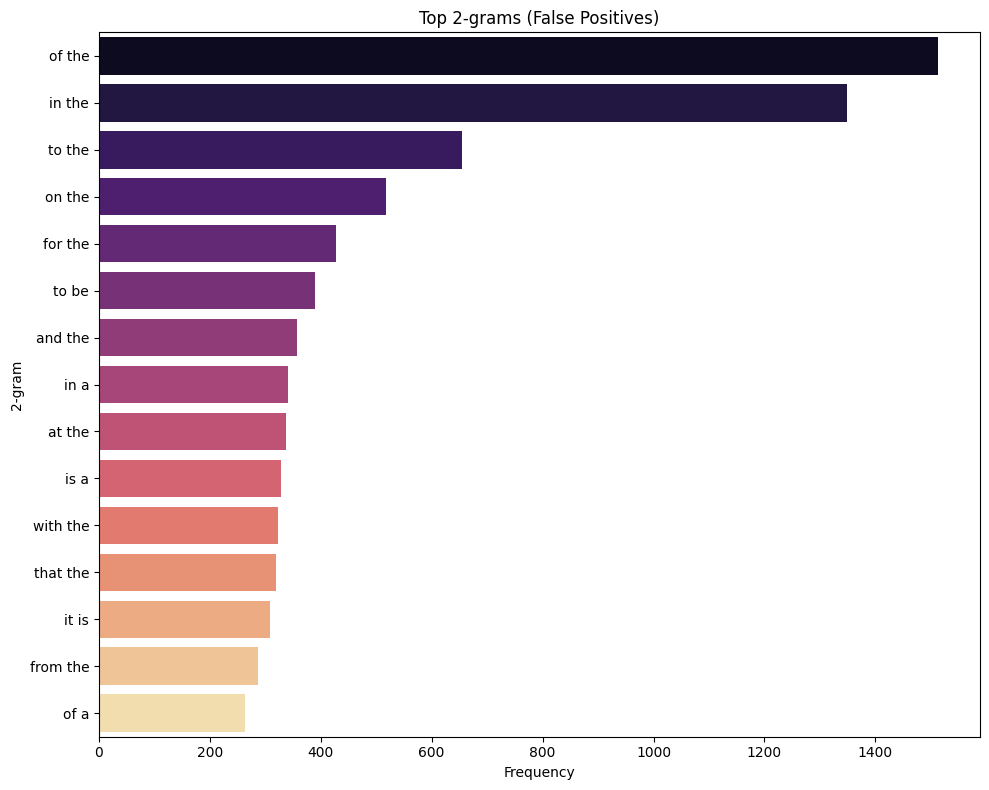

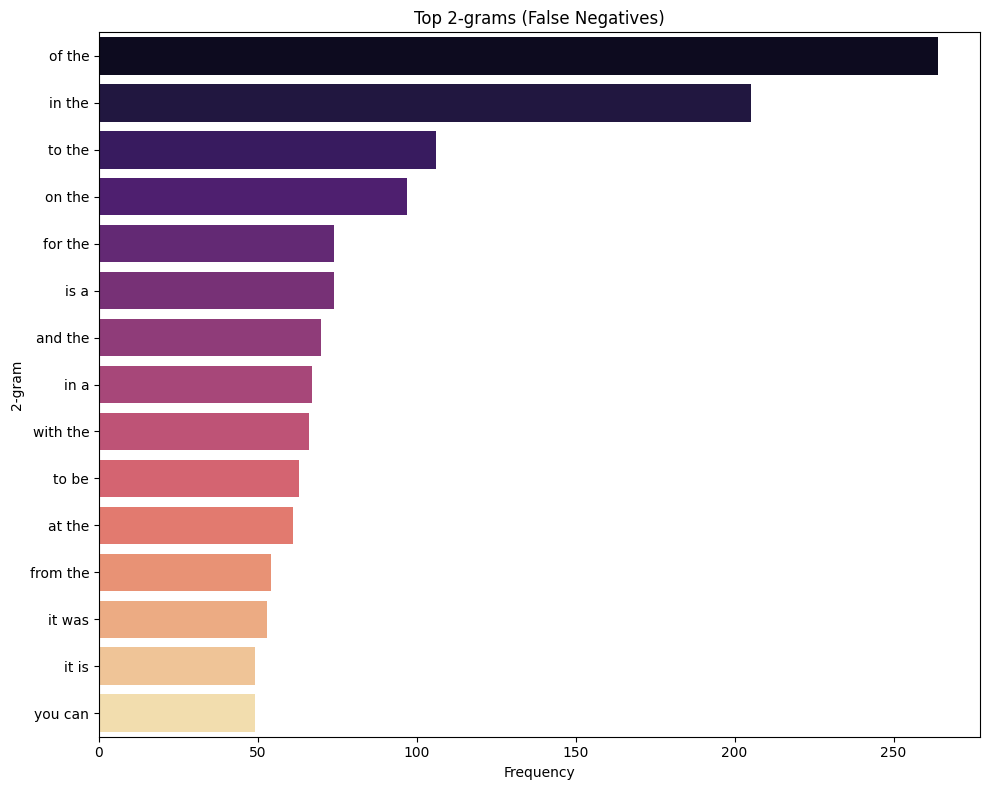

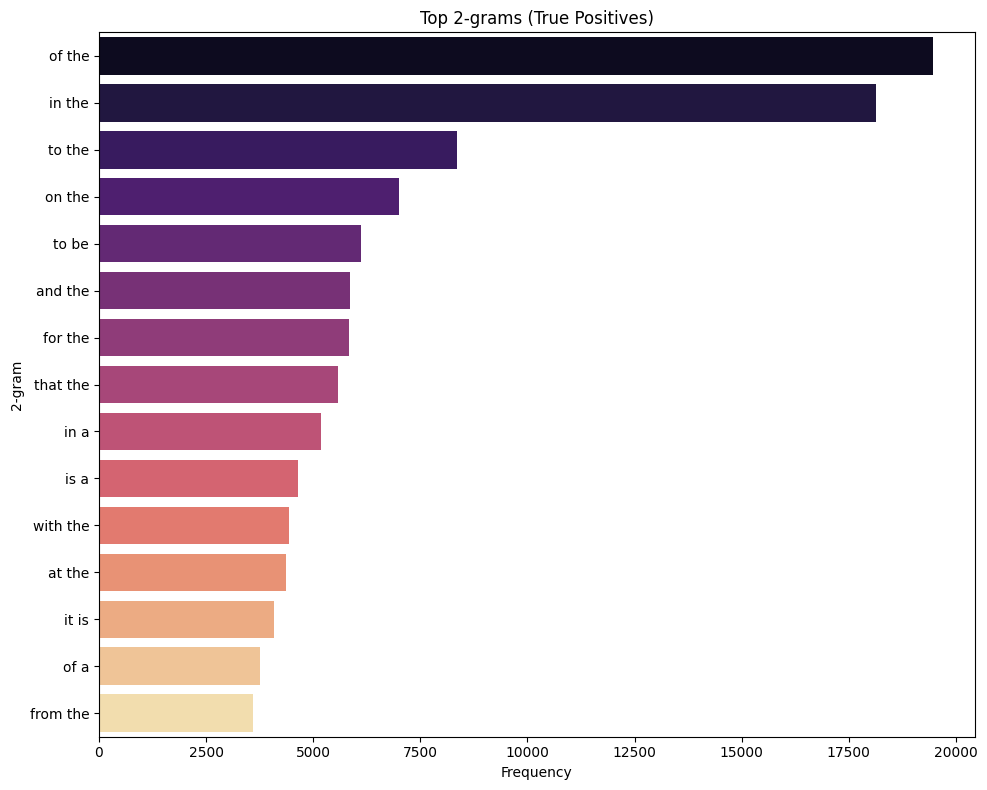


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       3075
1            a lot of       2426
2   the united states       2333
3          as well as       2005
4         in order to       1551
5          be able to       1538
6       the fact that       1399
7         some of the       1290
8    according to the       1250
9             to be a       1106
10        a number of       1093
11      the number of       1005
12        part of the       1003
13         there is a        961
14         the use of        911
15         the end of        892
16          this is a        864
17        as a result        863
18       in the world        863
19         out of the        861


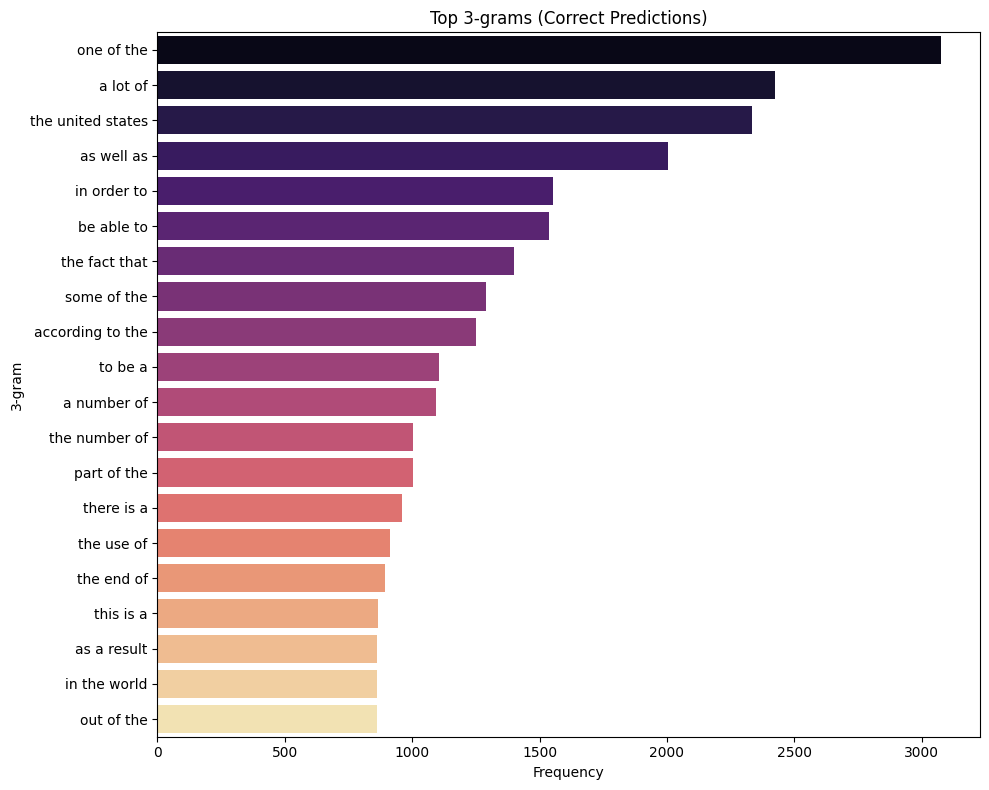


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        113
1            a lot of         91
2    according to the         77
3          as well as         76
4          be able to         71
5   the united states         67
6           this is a         65
7         some of the         58
8          the end of         54
9         part of the         51
10         out of the         42
11        in order to         42
12       in the world         38
13     the first time         38
14            to be a         37
15         end of the         36
16      the number of         36
17        you want to         36
18  the university of         34
19         there is a         34


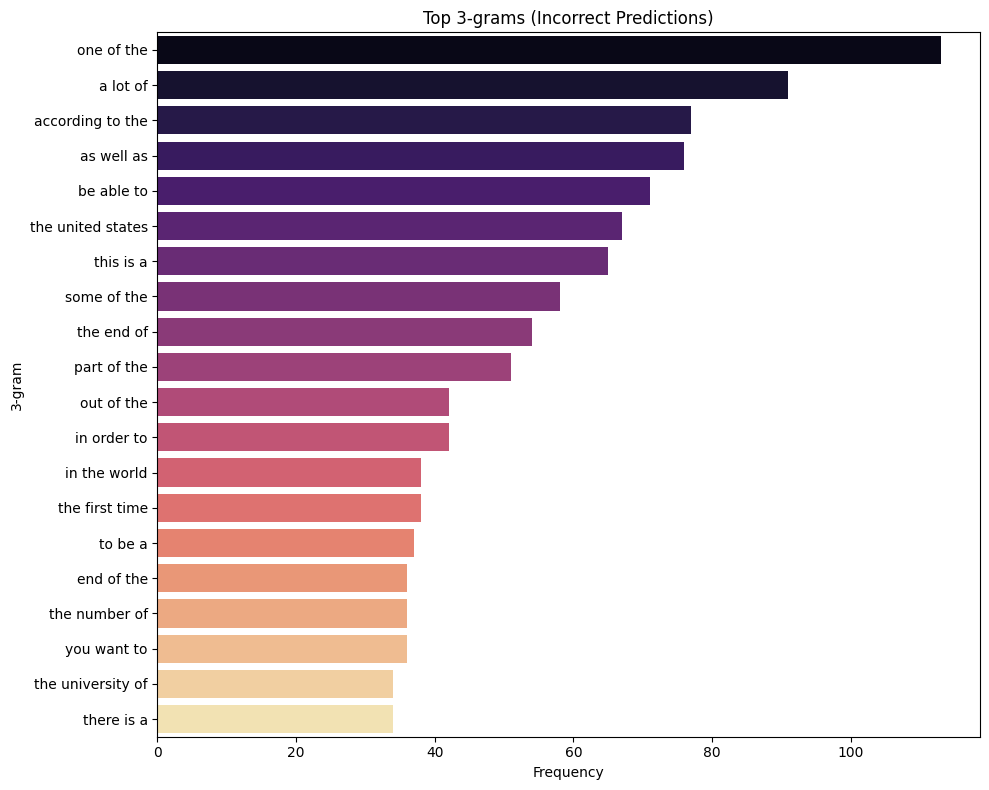

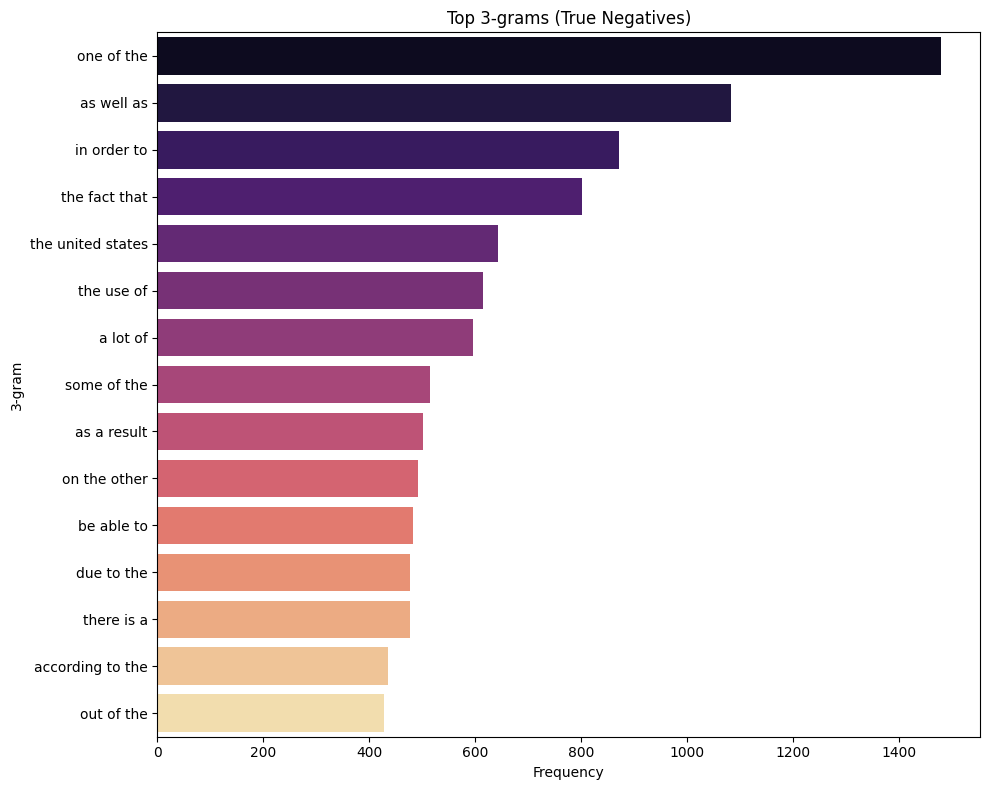

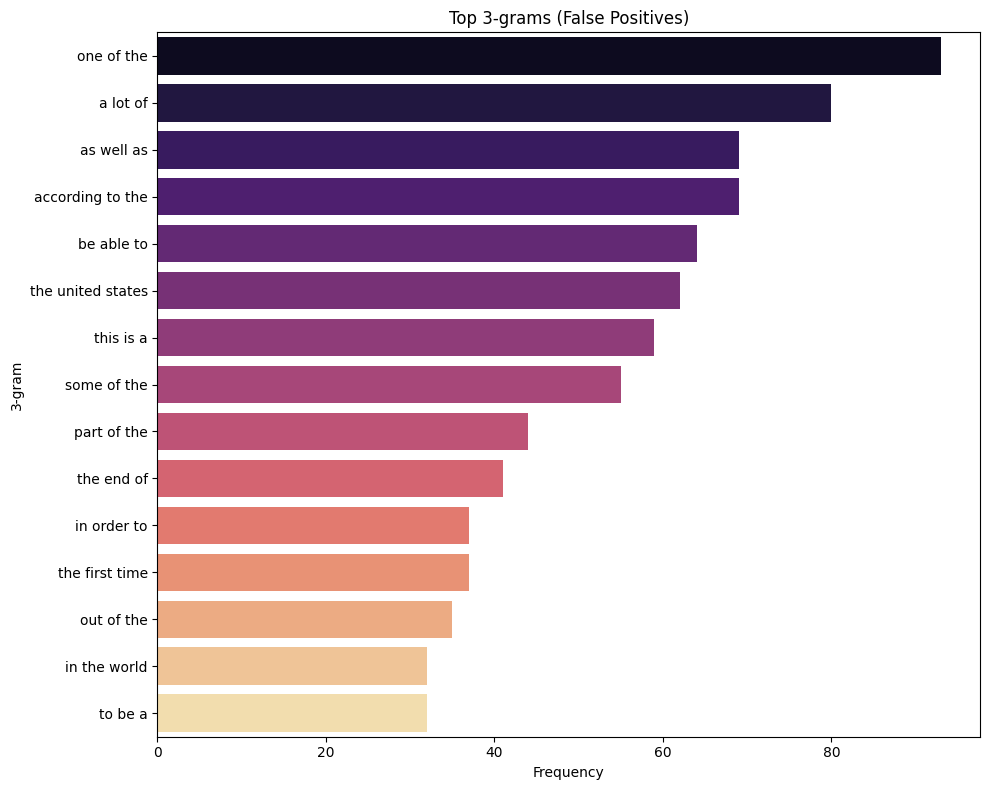

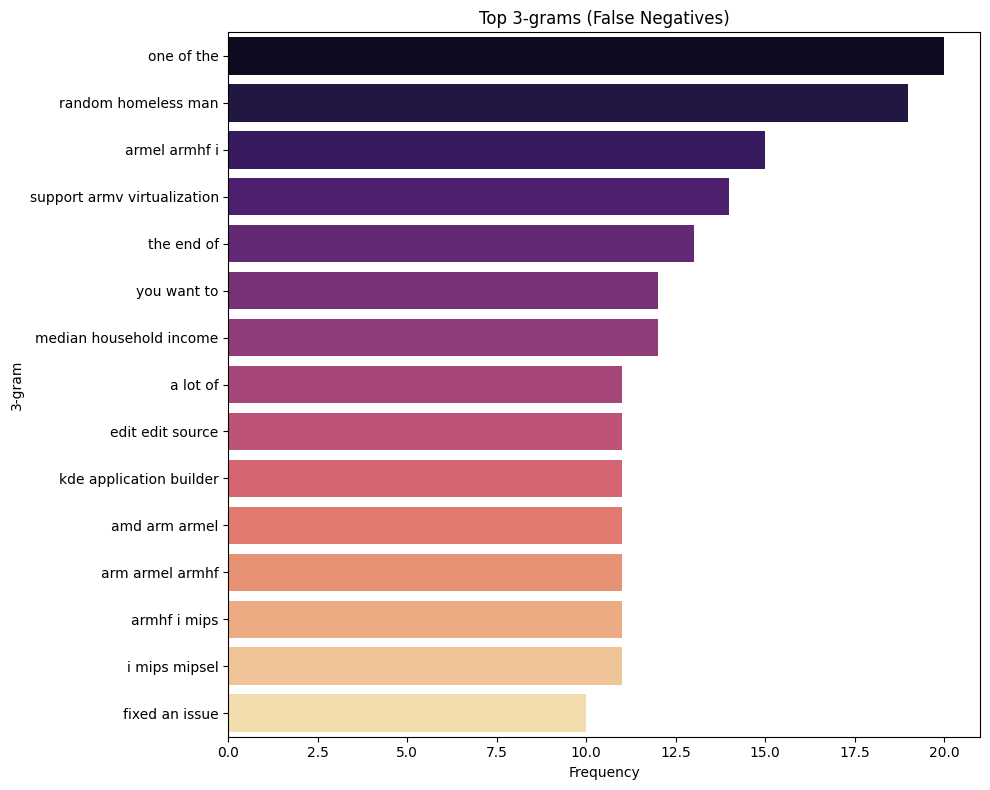

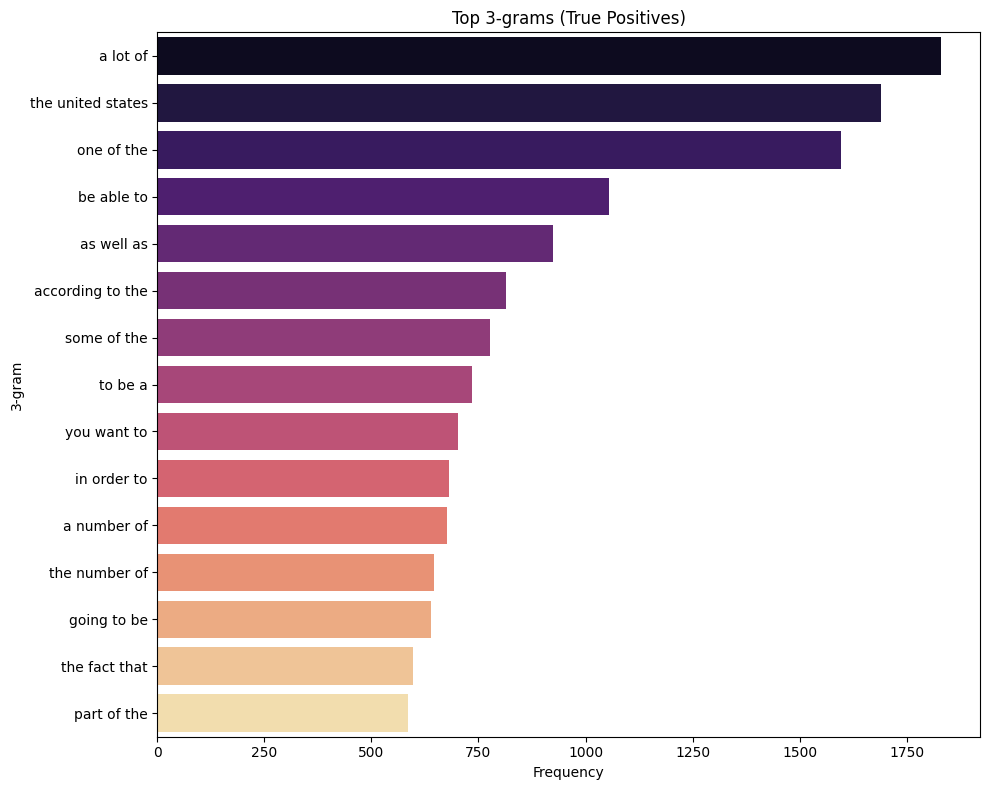


--- Analyzing Prediction Confidence ---


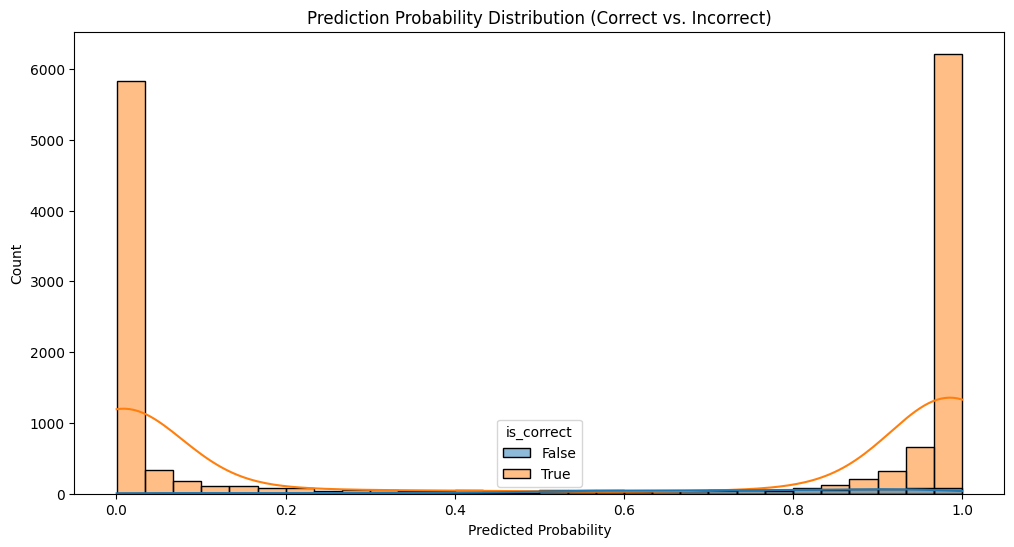


Average Prediction Probability:
is_correct
False    0.696959
True     0.527082
Name: pred_probability, dtype: float32

--- Analyzing Prediction Confidence by result type ---


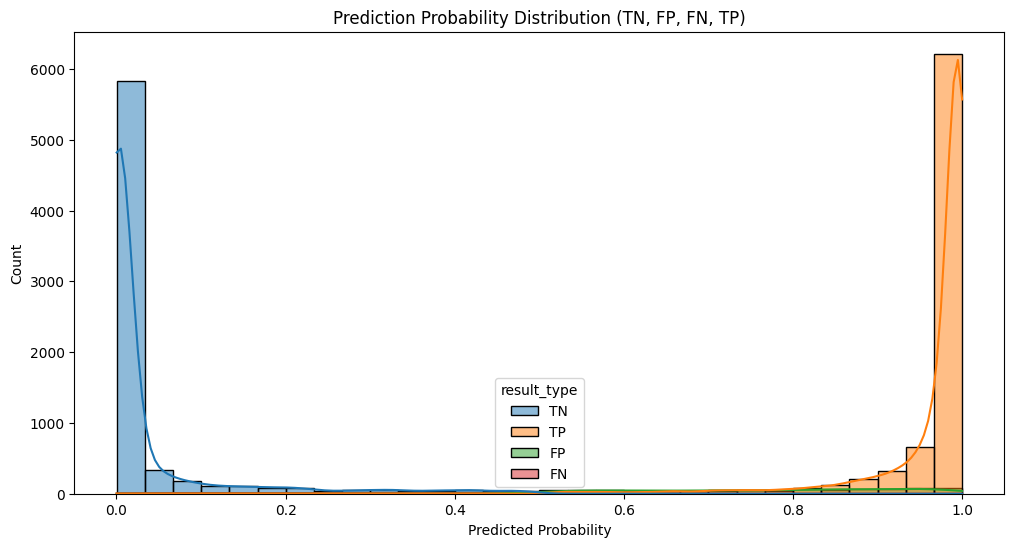


Average Prediction Probability:
result_type
FN    0.259171
FP    0.777088
TN    0.035382
TP    0.966828
Name: pred_probability, dtype: float32

--- Analyzing High-Confidence Errors Examples ---
Found 229 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 847 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9985
  Text Snippet:     we just got another extremely disappointing gdp number it was being projected that us gdp would grow by percent during the second quarter of but instead it only grew by just percent in addition the census bureau announced that gdp growth for the first quarter of had been revised down from percent to percent what this means is that the us economy is just barely hanging on by its fingernails from falling into a recession as zero hedge has pointed out the average annual growth rate during the curre...
--------------------------

In [2]:
### Distilbert LoRA with features error analysis
main(
    validation_data="data/text_validation.csv",
    model="finetuned_model/distilbert_lora_with_features_finetuned_detector",
    use_features="True"
)